## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


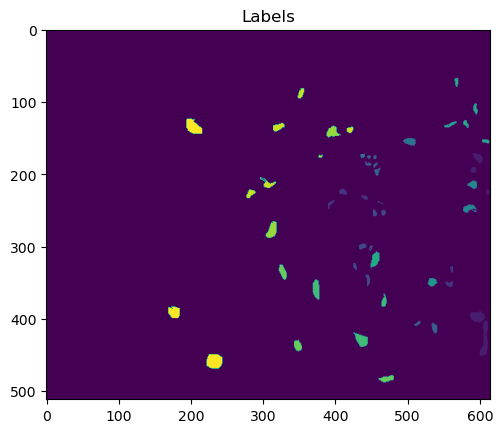

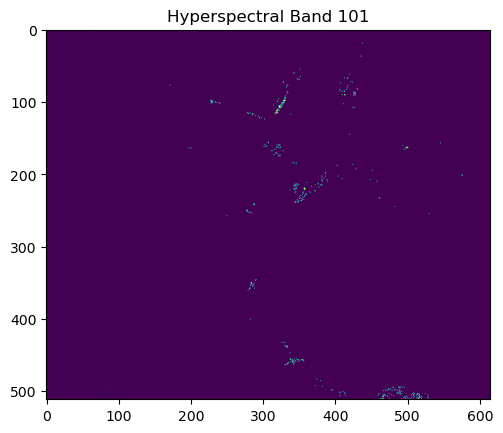

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Selected 5


All datasets saved to the 'indices' folder.
(65, 5, 5, 176)
(65, 5, 5, 176)
(5081, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 65
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2501, PSNR: 6.0193


Epoch [1/50] Training Loss: 0.2381, PSNR: 6.2351
	[Val]   Batch [1/17] Loss: 0.2224, PSNR: 6.5278
	[Val]   Batch [10/17] Loss: 0.2229, PSNR: 6.5181
Epoch [1/50] Validation Loss: 0.2227, PSNR: 6.5221

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2160, PSNR: 6.6563


Epoch [2/50] Training Loss: 0.2011, PSNR: 6.9712
	[Val]   Batch [1/17] Loss: 0.1781, PSNR: 7.4936
	[Val]   Batch [10/17] Loss: 0.1806, PSNR: 7.4332
Epoch [2/50] Validation Loss: 0.1795, PSNR: 7.4588

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1792, PSNR: 7.4672


Epoch [3/50] Training Loss: 0.1649, PSNR: 7.8351
	[Val]   Batch [1/17] Loss: 0.1435, PSNR: 8.4304
	[Val]   Batch [10/17] Loss: 0.1466, PSNR: 8.3395
Epoch [3/50] Validation Loss: 0.1455, PSNR: 8.3723

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1451, PSNR: 8.3821


Epoch [4/50] Training Loss: 0.1329, PSNR: 8.0899
	[Val]   Batch [1/17] Loss: 0.1150, PSNR: 9.3935
	[Val]   Batch [10/17] Loss: 0.1169, PSNR: 9.3235
Epoch [4/50] Validation Loss: 0.1162, PSNR: 9.3464

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1161, PSNR: 9.3502


Epoch [5/50] Training Loss: 0.1062, PSNR: 9.7460
	[Val]   Batch [1/17] Loss: 0.0933, PSNR: 10.2998
	[Val]   Batch [10/17] Loss: 0.0948, PSNR: 10.2328
Epoch [5/50] Validation Loss: 0.0943, PSNR: 10.2549

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0929, PSNR: 10.3200


Epoch [6/50] Training Loss: 0.0850, PSNR: 10.0294
	[Val]   Batch [1/17] Loss: 0.0756, PSNR: 11.2126
	[Val]   Batch [10/17] Loss: 0.0767, PSNR: 11.1534
Epoch [6/50] Validation Loss: 0.0763, PSNR: 11.1757

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0746, PSNR: 11.2740


Epoch [7/50] Training Loss: 0.0686, PSNR: 11.6465
	[Val]   Batch [1/17] Loss: 0.0612, PSNR: 12.1355
	[Val]   Batch [10/17] Loss: 0.0616, PSNR: 12.1057
Epoch [7/50] Validation Loss: 0.0614, PSNR: 12.1179

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0606, PSNR: 12.1774


Epoch [8/50] Training Loss: 0.0561, PSNR: 12.5162
	[Val]   Batch [1/17] Loss: 0.0507, PSNR: 12.9484
	[Val]   Batch [10/17] Loss: 0.0513, PSNR: 12.8949
Epoch [8/50] Validation Loss: 0.0511, PSNR: 12.9187

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0500, PSNR: 13.0073


Epoch [9/50] Training Loss: 0.0466, PSNR: 13.3175
	[Val]   Batch [1/17] Loss: 0.0431, PSNR: 13.6564
	[Val]   Batch [10/17] Loss: 0.0436, PSNR: 13.6080
Epoch [9/50] Validation Loss: 0.0433, PSNR: 13.6318

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0418, PSNR: 13.7890


Epoch [10/50] Training Loss: 0.0395, PSNR: 14.0406
	[Val]   Batch [1/17] Loss: 0.0371, PSNR: 14.3107
	[Val]   Batch [10/17] Loss: 0.0374, PSNR: 14.2704
Epoch [10/50] Validation Loss: 0.0372, PSNR: 14.2920

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0358, PSNR: 14.4580


Epoch [11/50] Training Loss: 0.0339, PSNR: 14.7061
	[Val]   Batch [1/17] Loss: 0.0320, PSNR: 14.9480
	[Val]   Batch [10/17] Loss: 0.0325, PSNR: 14.8859
Epoch [11/50] Validation Loss: 0.0323, PSNR: 14.9123

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0310, PSNR: 15.0903


Epoch [12/50] Training Loss: 0.0295, PSNR: 15.3113
	[Val]   Batch [1/17] Loss: 0.0278, PSNR: 15.5591
	[Val]   Batch [10/17] Loss: 0.0280, PSNR: 15.5305
Epoch [12/50] Validation Loss: 0.0279, PSNR: 15.5472

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0272, PSNR: 15.6548


Epoch [13/50] Training Loss: 0.0258, PSNR: 15.8779
	[Val]   Batch [1/17] Loss: 0.0246, PSNR: 16.0871
	[Val]   Batch [10/17] Loss: 0.0249, PSNR: 16.0337
Epoch [13/50] Validation Loss: 0.0248, PSNR: 16.0565

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0239, PSNR: 16.2236


Epoch [14/50] Training Loss: 0.0229, PSNR: 16.4053
	[Val]   Batch [1/17] Loss: 0.0219, PSNR: 16.6008
	[Val]   Batch [10/17] Loss: 0.0221, PSNR: 16.5486
Epoch [14/50] Validation Loss: 0.0220, PSNR: 16.5744

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0216, PSNR: 16.6597


Epoch [15/50] Training Loss: 0.0205, PSNR: 16.8947
	[Val]   Batch [1/17] Loss: 0.0199, PSNR: 17.0103
	[Val]   Batch [10/17] Loss: 0.0202, PSNR: 16.9553
Epoch [15/50] Validation Loss: 0.0200, PSNR: 16.9812

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0190, PSNR: 17.2063


Epoch [16/50] Training Loss: 0.0184, PSNR: 17.3513
	[Val]   Batch [1/17] Loss: 0.0179, PSNR: 17.4836
	[Val]   Batch [10/17] Loss: 0.0180, PSNR: 17.4421
Epoch [16/50] Validation Loss: 0.0179, PSNR: 17.4619

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0174, PSNR: 17.6059


Epoch [17/50] Training Loss: 0.0167, PSNR: 17.7842
	[Val]   Batch [1/17] Loss: 0.0163, PSNR: 17.8683
	[Val]   Batch [10/17] Loss: 0.0166, PSNR: 17.8097
Epoch [17/50] Validation Loss: 0.0165, PSNR: 17.8331

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0158, PSNR: 18.0070


Epoch [18/50] Training Loss: 0.0152, PSNR: 18.1852
	[Val]   Batch [1/17] Loss: 0.0148, PSNR: 18.2965
	[Val]   Batch [10/17] Loss: 0.0150, PSNR: 18.2424
Epoch [18/50] Validation Loss: 0.0149, PSNR: 18.2670

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0145, PSNR: 18.3774


Epoch [19/50] Training Loss: 0.0139, PSNR: 18.5680
	[Val]   Batch [1/17] Loss: 0.0136, PSNR: 18.6755
	[Val]   Batch [10/17] Loss: 0.0137, PSNR: 18.6202
Epoch [19/50] Validation Loss: 0.0137, PSNR: 18.6436

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0132, PSNR: 18.7779


Epoch [20/50] Training Loss: 0.0128, PSNR: 18.9262
	[Val]   Batch [1/17] Loss: 0.0126, PSNR: 19.0055
	[Val]   Batch [10/17] Loss: 0.0128, PSNR: 18.9443
Epoch [20/50] Validation Loss: 0.0127, PSNR: 18.9688

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0122, PSNR: 19.1442


Epoch [21/50] Training Loss: 0.0118, PSNR: 19.2731
	[Val]   Batch [1/17] Loss: 0.0116, PSNR: 19.3583
	[Val]   Batch [10/17] Loss: 0.0118, PSNR: 19.2951
Epoch [21/50] Validation Loss: 0.0117, PSNR: 19.3227

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0114, PSNR: 19.4235


Epoch [22/50] Training Loss: 0.0110, PSNR: 19.5972
	[Val]   Batch [1/17] Loss: 0.0108, PSNR: 19.6727
	[Val]   Batch [10/17] Loss: 0.0109, PSNR: 19.6090
Epoch [22/50] Validation Loss: 0.0109, PSNR: 19.6354

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0106, PSNR: 19.7453


Epoch [23/50] Training Loss: 0.0102, PSNR: 19.9176
	[Val]   Batch [1/17] Loss: 0.0100, PSNR: 19.9958
	[Val]   Batch [10/17] Loss: 0.0102, PSNR: 19.9227
Epoch [23/50] Validation Loss: 0.0101, PSNR: 19.9530

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0098, PSNR: 20.1074


Epoch [24/50] Training Loss: 0.0095, PSNR: 19.5166
	[Val]   Batch [1/17] Loss: 0.0096, PSNR: 20.1907
	[Val]   Batch [10/17] Loss: 0.0097, PSNR: 20.1177
Epoch [24/50] Validation Loss: 0.0097, PSNR: 20.1503

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0091, PSNR: 20.4256


Epoch [25/50] Training Loss: 0.0089, PSNR: 19.8172
	[Val]   Batch [1/17] Loss: 0.0090, PSNR: 20.4766
	[Val]   Batch [10/17] Loss: 0.0091, PSNR: 20.3867
Epoch [25/50] Validation Loss: 0.0091, PSNR: 20.4237

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0086, PSNR: 20.6724


Epoch [26/50] Training Loss: 0.0083, PSNR: 20.7863
	[Val]   Batch [1/17] Loss: 0.0083, PSNR: 20.8217
	[Val]   Batch [10/17] Loss: 0.0085, PSNR: 20.7293
Epoch [26/50] Validation Loss: 0.0084, PSNR: 20.7681

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0080, PSNR: 20.9872


Epoch [27/50] Training Loss: 0.0079, PSNR: 21.0516
	[Val]   Batch [1/17] Loss: 0.0078, PSNR: 21.1058
	[Val]   Batch [10/17] Loss: 0.0079, PSNR: 21.0123
Epoch [27/50] Validation Loss: 0.0079, PSNR: 21.0504

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0075, PSNR: 21.2295


Epoch [28/50] Training Loss: 0.0074, PSNR: 21.3160
	[Val]   Batch [1/17] Loss: 0.0073, PSNR: 21.3640
	[Val]   Batch [10/17] Loss: 0.0075, PSNR: 21.2650
Epoch [28/50] Validation Loss: 0.0074, PSNR: 21.3056

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0073, PSNR: 21.3651


Epoch [29/50] Training Loss: 0.0070, PSNR: 21.5610
	[Val]   Batch [1/17] Loss: 0.0070, PSNR: 21.5661
	[Val]   Batch [10/17] Loss: 0.0071, PSNR: 21.4701
Epoch [29/50] Validation Loss: 0.0071, PSNR: 21.5116

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0070, PSNR: 21.5791


Epoch [30/50] Training Loss: 0.0066, PSNR: 21.8098
	[Val]   Batch [1/17] Loss: 0.0065, PSNR: 21.8610
	[Val]   Batch [10/17] Loss: 0.0067, PSNR: 21.7533
Epoch [30/50] Validation Loss: 0.0066, PSNR: 21.7980

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0063, PSNR: 22.0247


Epoch [31/50] Training Loss: 0.0062, PSNR: 22.0429
	[Val]   Batch [1/17] Loss: 0.0063, PSNR: 22.0309
	[Val]   Batch [10/17] Loss: 0.0064, PSNR: 21.9133
Epoch [31/50] Validation Loss: 0.0064, PSNR: 21.9622

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0061, PSNR: 22.1529


Epoch [32/50] Training Loss: 0.0059, PSNR: 21.5997
	[Val]   Batch [1/17] Loss: 0.0060, PSNR: 22.2542
	[Val]   Batch [10/17] Loss: 0.0061, PSNR: 22.1425
Epoch [32/50] Validation Loss: 0.0060, PSNR: 22.1884

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0056, PSNR: 22.4988


Epoch [33/50] Training Loss: 0.0056, PSNR: 21.8168
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.4932
	[Val]   Batch [10/17] Loss: 0.0058, PSNR: 22.3617
Epoch [33/50] Validation Loss: 0.0057, PSNR: 22.4138

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0054, PSNR: 22.6941


Epoch [34/50] Training Loss: 0.0054, PSNR: 22.7156
	[Val]   Batch [1/17] Loss: 0.0053, PSNR: 22.7730
	[Val]   Batch [10/17] Loss: 0.0054, PSNR: 22.6374
Epoch [34/50] Validation Loss: 0.0054, PSNR: 22.6908

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0053, PSNR: 22.7838


Epoch [35/50] Training Loss: 0.0051, PSNR: 22.9209
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.9434
	[Val]   Batch [10/17] Loss: 0.0052, PSNR: 22.8219
Epoch [35/50] Validation Loss: 0.0052, PSNR: 22.8711

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0049, PSNR: 23.1037


Epoch [36/50] Training Loss: 0.0049, PSNR: 23.1352
	[Val]   Batch [1/17] Loss: 0.0048, PSNR: 23.1675
	[Val]   Batch [10/17] Loss: 0.0050, PSNR: 23.0317
Epoch [36/50] Validation Loss: 0.0049, PSNR: 23.0856

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0049, PSNR: 23.0950


Epoch [37/50] Training Loss: 0.0046, PSNR: 23.3293
	[Val]   Batch [1/17] Loss: 0.0046, PSNR: 23.3471
	[Val]   Batch [10/17] Loss: 0.0048, PSNR: 23.1984
Epoch [37/50] Validation Loss: 0.0047, PSNR: 23.2562

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0046, PSNR: 23.3704


Epoch [38/50] Training Loss: 0.0044, PSNR: 22.8502
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5575
	[Val]   Batch [10/17] Loss: 0.0046, PSNR: 23.4084
Epoch [38/50] Validation Loss: 0.0045, PSNR: 23.4677

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0044, PSNR: 23.5959


Epoch [39/50] Training Loss: 0.0043, PSNR: 23.7157
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7628
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.6040
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.6650

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.7202


Epoch [40/50] Training Loss: 0.0041, PSNR: 23.2133
	[Val]   Batch [1/17] Loss: 0.0041, PSNR: 23.9168
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.7559
Epoch [40/50] Validation Loss: 0.0042, PSNR: 23.8174

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 24.0315


Epoch [41/50] Training Loss: 0.0039, PSNR: 24.0909
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.1084
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 23.9404
Epoch [41/50] Validation Loss: 0.0040, PSNR: 24.0064

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0038, PSNR: 24.2528


Epoch [42/50] Training Loss: 0.0037, PSNR: 24.2654
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.3063
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.1272
Epoch [42/50] Validation Loss: 0.0038, PSNR: 24.1960

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.5015


Epoch [43/50] Training Loss: 0.0036, PSNR: 24.4238
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.4463
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.2574
Epoch [43/50] Validation Loss: 0.0037, PSNR: 24.3299

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.5330


Epoch [44/50] Training Loss: 0.0035, PSNR: 24.5948
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.6412
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4547
Epoch [44/50] Validation Loss: 0.0035, PSNR: 24.5262

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.7166


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.7604
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.7860
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.5917
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.6659

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.0171


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.9274
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.0243
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.8149
Epoch [46/50] Validation Loss: 0.0032, PSNR: 24.8934

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.7691


Epoch [47/50] Training Loss: 0.0031, PSNR: 24.3918
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1197
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9076
Epoch [47/50] Validation Loss: 0.0032, PSNR: 24.9886

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2668


Epoch [48/50] Training Loss: 0.0030, PSNR: 25.2311
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.2734
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.0613
Epoch [48/50] Validation Loss: 0.0031, PSNR: 25.1411

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.4713


Epoch [49/50] Training Loss: 0.0029, PSNR: 24.7027
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3806
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.1546
Epoch [49/50] Validation Loss: 0.0030, PSNR: 25.2408

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2669


Epoch [50/50] Training Loss: 0.0028, PSNR: 25.5269
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.6000
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3718
Epoch [50/50] Validation Loss: 0.0028, PSNR: 25.4583


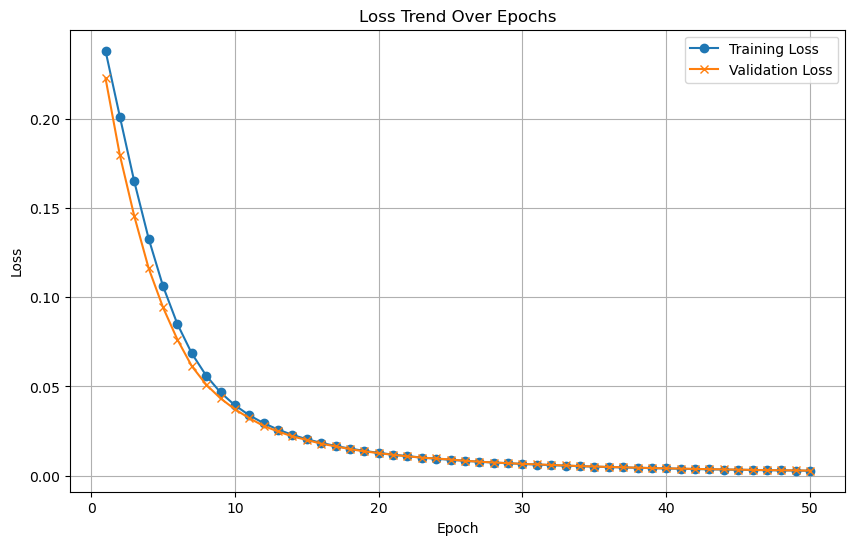

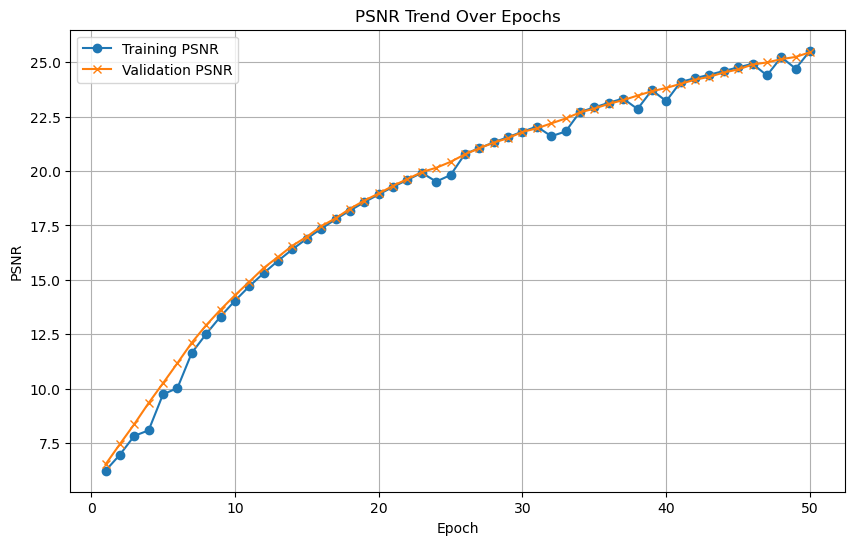

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5657
    Validation Batch [1/1], Loss: 2.5703
Validation Loss: 2.5703, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5703. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5516
    Validation Batch [1/1], Loss: 2.5703
Validation Loss: 2.5703, Validation Accuracy: 7.69%
Validation loss improved from 2.5703 to 2.5703. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5440
    Validation Batch [1/1], Loss: 2.5702
Validation Loss: 2.5702, Validation Accuracy: 7.69%
Validation loss improved from 2.5703 to 2.5702. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5144
    Validation Batch [1/1], Loss: 2.5702
Validation Loss: 2.5702, Validation Accuracy: 7.69%
Validation loss improved from 2.5702 to 2.5702. Saving model...

LOG: Epoch [5/1000] - 

Epoch [24/1000] completed, Average Training Loss: 2.4085
    Validation Batch [1/1], Loss: 2.5696
Validation Loss: 2.5696, Validation Accuracy: 7.69%
Validation loss improved from 2.5697 to 2.5696. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.4083
    Validation Batch [1/1], Loss: 2.5696
Validation Loss: 2.5696, Validation Accuracy: 10.77%
Validation loss improved from 2.5696 to 2.5696. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.3957
    Validation Batch [1/1], Loss: 2.5696
Validation Loss: 2.5696, Validation Accuracy: 9.23%
Validation loss improved from 2.5696 to 2.5696. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.4078
    Validation Batch [1/1], Loss: 2.5695
Validation Loss: 2.5695, Validation Accuracy: 9.23%
Validation loss improved from 2.5696 to 2.5695. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/1

Epoch [56/1000] completed, Average Training Loss: 2.1487
    Validation Batch [1/1], Loss: 2.5471
Validation Loss: 2.5471, Validation Accuracy: 13.85%
Validation loss improved from 2.5497 to 2.5471. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 2.1527
    Validation Batch [1/1], Loss: 2.5444
Validation Loss: 2.5444, Validation Accuracy: 12.31%
Validation loss improved from 2.5471 to 2.5444. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 2.1828
    Validation Batch [1/1], Loss: 2.5416
Validation Loss: 2.5416, Validation Accuracy: 12.31%
Validation loss improved from 2.5444 to 2.5416. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 2.1467
    Validation Batch [1/1], Loss: 2.5385
Validation Loss: 2.5385, Validation Accuracy: 12.31%
Validation loss improved from 2.5416 to 2.5385. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 2.3331
Validation Loss: 2.3331, Validation Accuracy: 20.00%
Validation loss improved from 2.3440 to 2.3331. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.9451
    Validation Batch [1/1], Loss: 2.3218
Validation Loss: 2.3218, Validation Accuracy: 21.54%
Validation loss improved from 2.3331 to 2.3218. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.9160
    Validation Batch [1/1], Loss: 2.3093
Validation Loss: 2.3093, Validation Accuracy: 21.54%
Validation loss improved from 2.3218 to 2.3093. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.9600
    Validation Batch [1/1], Loss: 2.2954
Validation Loss: 2.2954, Validation Accuracy: 21.54%
Validation loss improved from 2.3093 to 2.2954. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.8966
    Vali

    Validation Batch [1/1], Loss: 2.0246
Validation Loss: 2.0246, Validation Accuracy: 49.23%
Validation loss improved from 2.0345 to 2.0246. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.6451
    Validation Batch [1/1], Loss: 2.0125
Validation Loss: 2.0125, Validation Accuracy: 49.23%
Validation loss improved from 2.0246 to 2.0125. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.6166
    Validation Batch [1/1], Loss: 2.0024
Validation Loss: 2.0024, Validation Accuracy: 49.23%
Validation loss improved from 2.0125 to 2.0024. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.6168
    Validation Batch [1/1], Loss: 1.9962
Validation Loss: 1.9962, Validation Accuracy: 49.23%
Validation loss improved from 2.0024 to 1.9962. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.6245


Validation Loss: 1.7916, Validation Accuracy: 50.77%
Validation loss improved from 1.7917 to 1.7916. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.3112
    Validation Batch [1/1], Loss: 1.7930
Validation Loss: 1.7930, Validation Accuracy: 49.23%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.3257
    Validation Batch [1/1], Loss: 1.7963
Validation Loss: 1.7963, Validation Accuracy: 50.77%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.3072
    Validation Batch [1/1], Loss: 1.7848
Validation Loss: 1.7848, Validation Accuracy: 50.77%
Validation loss improved from 1.7916 to 1.7848. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.3763
    Validation Batch [1/1], Loss: 1.7731
Validation Loss: 1.7731, Valid

Epoch [182/1000] completed, Average Training Loss: 1.0991
    Validation Batch [1/1], Loss: 1.6511
Validation Loss: 1.6511, Validation Accuracy: 56.92%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.0924
    Validation Batch [1/1], Loss: 1.6422
Validation Loss: 1.6422, Validation Accuracy: 56.92%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 1.0343
    Validation Batch [1/1], Loss: 1.6183
Validation Loss: 1.6183, Validation Accuracy: 58.46%
Validation loss improved from 1.6273 to 1.6183. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 1.0450
    Validation Batch [1/1], Loss: 1.5979
Validation Loss: 1.5979, Validation Accuracy: 61.54%
Validation loss improved from 1.6183 to 1.5979. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Av

    Validation Batch [1/1], Loss: 1.4622
Validation Loss: 1.4622, Validation Accuracy: 64.62%
Validation loss improved from 1.4765 to 1.4622. Saving model...

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.7827
    Validation Batch [1/1], Loss: 1.4545
Validation Loss: 1.4545, Validation Accuracy: 64.62%
Validation loss improved from 1.4622 to 1.4545. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.7619
    Validation Batch [1/1], Loss: 1.4689
Validation Loss: 1.4689, Validation Accuracy: 58.46%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.7713
    Validation Batch [1/1], Loss: 1.4791
Validation Loss: 1.4791, Validation Accuracy: 58.46%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.7958
    Validation Batch [1/1], Lo

Epoch [248/1000] completed, Average Training Loss: 0.6085
    Validation Batch [1/1], Loss: 1.4162
Validation Loss: 1.4162, Validation Accuracy: 61.54%
Validation loss improved from 1.4220 to 1.4162. Saving model...

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.5480
    Validation Batch [1/1], Loss: 1.4164
Validation Loss: 1.4164, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.5737
    Validation Batch [1/1], Loss: 1.4075
Validation Loss: 1.4075, Validation Accuracy: 61.54%
Validation loss improved from 1.4162 to 1.4075. Saving model...

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.6252
    Validation Batch [1/1], Loss: 1.3956
Validation Loss: 1.3956, Validation Accuracy: 61.54%
Validation loss improved from 1.4075 to 1.3956. Saving model...

LOG: Epoch [252/1000] - Training
Epoch [252/1000

Epoch [281/1000] completed, Average Training Loss: 0.4501
    Validation Batch [1/1], Loss: 1.4699
Validation Loss: 1.4699, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.4236
    Validation Batch [1/1], Loss: 1.4696
Validation Loss: 1.4696, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.3999
    Validation Batch [1/1], Loss: 1.4665
Validation Loss: 1.4665, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.4289
    Validation Batch [1/1], Loss: 1.4633
Validation Loss: 1.4633, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.453

    Validation Batch [1/1], Loss: 1.5450
Validation Loss: 1.5450, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.3159
    Validation Batch [1/1], Loss: 1.5419
Validation Loss: 1.5419, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.3366
    Validation Batch [1/1], Loss: 1.5281
Validation Loss: 1.5281, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.2646
    Validation Batch [1/1], Loss: 1.5260
Validation Loss: 1.5260, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.3314
    Validation Batch [1/1], Loss: 1.5357
Validation Loss

Epoch [343/1000] completed, Average Training Loss: 0.2375
    Validation Batch [1/1], Loss: 1.6344
Validation Loss: 1.6344, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.2143
    Validation Batch [1/1], Loss: 1.6166
Validation Loss: 1.6166, Validation Accuracy: 58.46%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.2667
    Validation Batch [1/1], Loss: 1.5836
Validation Loss: 1.5836, Validation Accuracy: 56.92%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.2160
    Validation Batch [1/1], Loss: 1.5790
Validation Loss: 1.5790, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.234

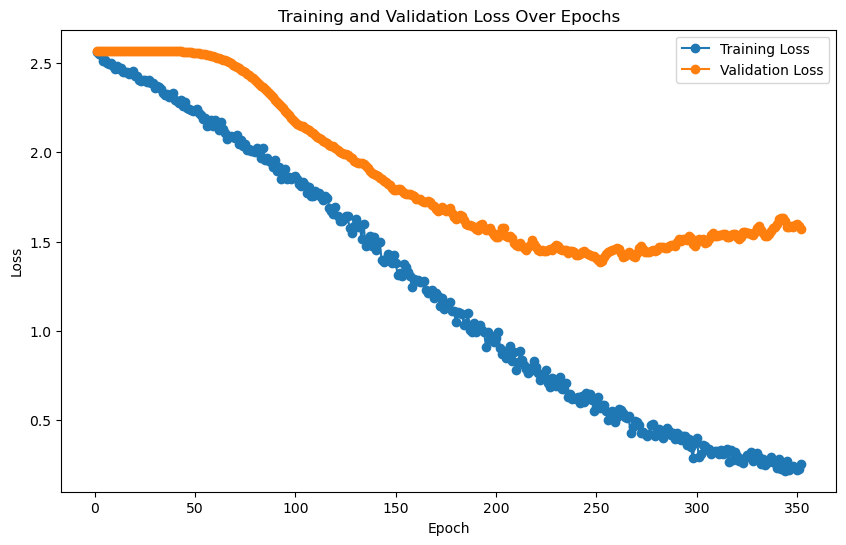

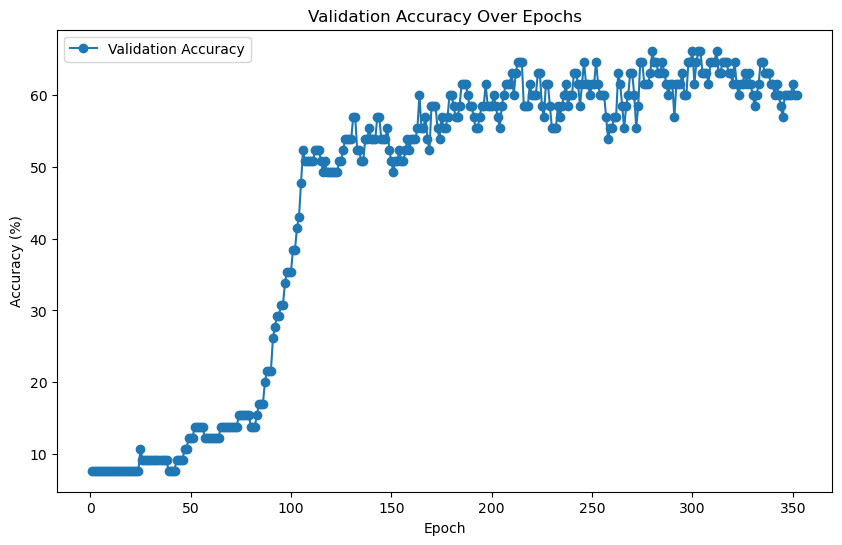


Evaluating on the test set...
    Test Batch [1/20], Loss: 1.3163

Final Test Loss: 1.6106, Test Accuracy: 69.73%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)

LOG: Training features shape: (65, 64), Training labels shape: (65,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (5081, 64), Test labels shape: (5081,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 38.46%

Validation Classification Report:
               precision    recall  f1-sco

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)
Train reps shape: (65, 64)
Train labels shape: (65,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (5081, 64)
Test labels shape: (5081,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6968  |  Val Loss: 2.6378
Validation loss improved from inf to 2.6378.
[Epoch 2/1000] Train Loss: 2.6161  |  Val Loss: 2.6111
Validation loss improved from 2.6378 to 2.6111.
[Epoch 3/1000] Train Loss: 2.5871  |  Val Loss: 2.5970
Validation loss improved from 2.6111 to 2.5970.
[Epoch 4/1000] Train Loss: 2.5729  |  Val Loss: 2.5859
Validation loss improved from 2.5970 to 2.5859.
[Epoch 5/1000] Train Loss: 2.5609  |  Val Loss: 2.5780
Validation loss improved from 2.5859 to 2.5780.
[Epoch 6/1000] Train Loss: 2.5508  |  Val Loss: 2.5753
Validation loss improved from 2.5780 to 2.5753.
[Epoch 7/1000] Train Loss: 2.5446  |  Val Loss: 2.5756
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 8/1000] Train Loss: 2.5429  |  Val Loss: 2.5759
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 9/1000] Train Loss: 2.5386  |  Val Loss: 2.5709
Validation loss improved from 2.5753 to 2.5709.
[Epoch 10/1000] Train Loss: 2.5299  |  Val Loss: 2.5624
Validati

[Epoch 36/1000] Train Loss: 2.4081  |  Val Loss: 2.4956
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 37/1000] Train Loss: 2.4095  |  Val Loss: 2.5020
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 38/1000] Train Loss: 2.4119  |  Val Loss: 2.5061
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 39/1000] Train Loss: 2.4123  |  Val Loss: 2.5084
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 40/1000] Train Loss: 2.4116  |  Val Loss: 2.5080
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 41/1000] Train Loss: 2.4104  |  Val Loss: 2.5056
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 42/1000] Train Loss: 2.4078  |  Val Loss: 2.5040
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 43/1000] Train Loss: 2.4055  |  Val Loss: 2.5014
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 44/1000] Train Loss: 2.4017  |  Val Loss: 2.4983
!! Validation loss did NOT improve !! Patience: 16/100
[Ep

[Epoch 80/1000] Train Loss: 2.3669  |  Val Loss: 2.5146
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 81/1000] Train Loss: 2.3644  |  Val Loss: 2.5121
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 82/1000] Train Loss: 2.3619  |  Val Loss: 2.5113
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 83/1000] Train Loss: 2.3614  |  Val Loss: 2.5122
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 84/1000] Train Loss: 2.3619  |  Val Loss: 2.5135
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 85/1000] Train Loss: 2.3616  |  Val Loss: 2.5146
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 86/1000] Train Loss: 2.3615  |  Val Loss: 2.5152
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 87/1000] Train Loss: 2.3620  |  Val Loss: 2.5154
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 88/1000] Train Loss: 2.3622  |  Val Loss: 2.5159
!! Validation loss did NOT improve !! Patience: 60/100
[

[Epoch 123/1000] Train Loss: 2.3363  |  Val Loss: 2.5422
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 124/1000] Train Loss: 2.3334  |  Val Loss: 2.5404
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 125/1000] Train Loss: 2.3316  |  Val Loss: 2.5400
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 126/1000] Train Loss: 2.3298  |  Val Loss: 2.5508
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 127/1000] Train Loss: 2.3339  |  Val Loss: 2.5711
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 128/1000] Train Loss: 2.3440  |  Val Loss: 2.5918
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 128 !!
No improvement for 100 epochs.


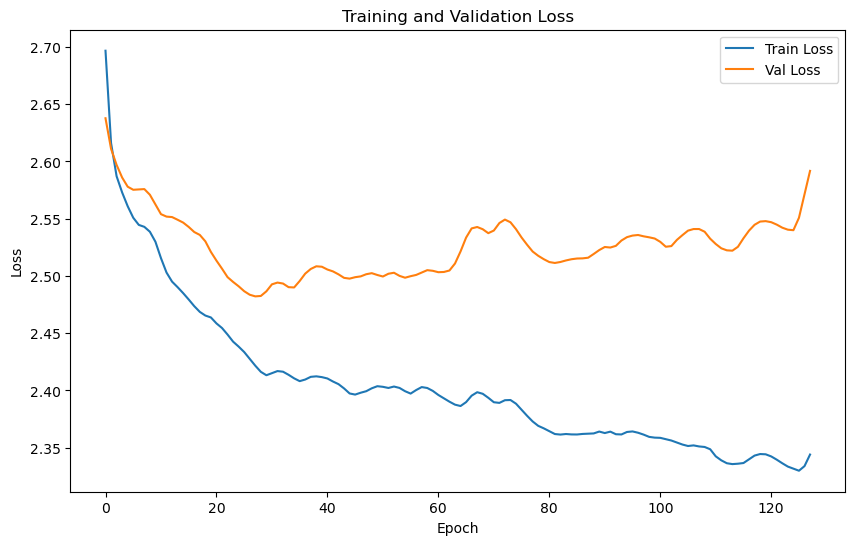

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.4957 | Test Accuracy: 9.86%


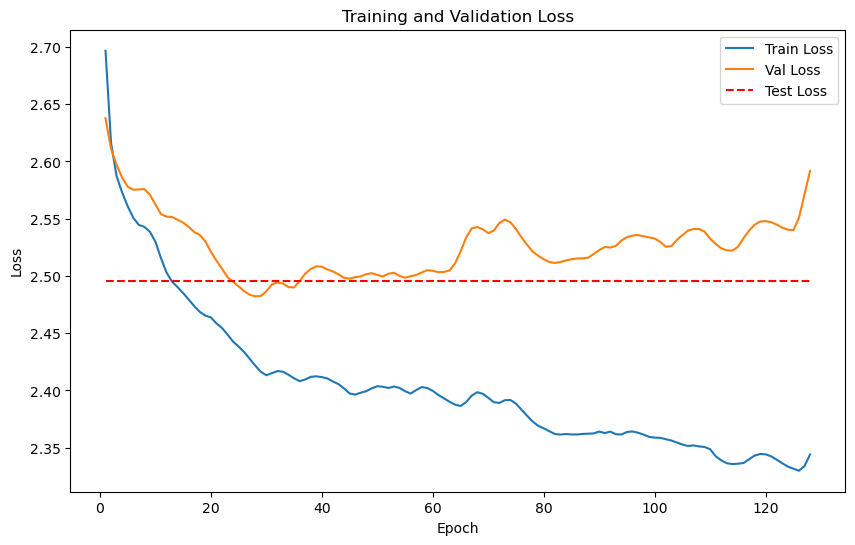

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)


Train embeddings shape: (65, 64), 
Train labels shape: (65,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5081, 64), 
Test labels shape: (5081,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}
Training batch size: 65


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 7.3142
Epoch [1/2000], Avg Train Loss: 7.3142
Epoch [1/2000], Avg Val Loss: 5.7944
Validation loss improved from inf to 5.7944. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.2568
Epoch [2/2000], Avg Train Loss: 7.2568
Epoch [2/2000], Avg Val Loss: 5.7754
Validation loss improved from 5.7944 to 5.7754. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.1922
Epoch [3/2000], Avg Train Loss: 7.1922
Epoch [3/2000], Avg Val Loss: 5.7566
Validation loss improved from 5.7754 to 5.7566. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.4677
Epoch [4/2000], Avg Train Loss: 7.4677
Epoch [4/2000], Avg Val Loss: 5.7372
Validation loss improved from 5.7566 to 5.7372. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.5220
Epoch [5/2000], Avg Train Loss: 7.5220
Epoch [5/2000], Avg Val Loss: 5.7178
Validation loss improved from 5.7372 to 5.7178. Saving mode

    Batch [1/1], Train Loss: 6.2169
Epoch [26/2000], Avg Train Loss: 6.2169
Epoch [26/2000], Avg Val Loss: 5.3045
Validation loss improved from 5.3245 to 5.3045. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.1758
Epoch [27/2000], Avg Train Loss: 6.1758
Epoch [27/2000], Avg Val Loss: 5.2845
Validation loss improved from 5.3045 to 5.2845. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 6.3636
Epoch [28/2000], Avg Train Loss: 6.3636
Epoch [28/2000], Avg Val Loss: 5.2645
Validation loss improved from 5.2845 to 5.2645. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 6.2654
Epoch [29/2000], Avg Train Loss: 6.2654
Epoch [29/2000], Avg Val Loss: 5.2447
Validation loss improved from 5.2645 to 5.2447. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 5.9023
Epoch [30/2000], Avg Train Loss: 5.9023
Epoch [30/2000], Avg Val Loss: 5.2249
Validation loss improved from 5.2447 to 5.

Epoch [36/2000], Avg Val Loss: 5.1061
Validation loss improved from 5.1255 to 5.1061. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 5.9668
Epoch [37/2000], Avg Train Loss: 5.9668
Epoch [37/2000], Avg Val Loss: 5.0867
Validation loss improved from 5.1061 to 5.0867. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 5.9681
Epoch [38/2000], Avg Train Loss: 5.9681
Epoch [38/2000], Avg Val Loss: 5.0675
Validation loss improved from 5.0867 to 5.0675. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 5.8885
Epoch [39/2000], Avg Train Loss: 5.8885
Epoch [39/2000], Avg Val Loss: 5.0483
Validation loss improved from 5.0675 to 5.0483. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 5.9836
Epoch [40/2000], Avg Train Loss: 5.9836
Epoch [40/2000], Avg Val Loss: 5.0292
Validation loss improved from 5.0483 to 5.0292. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.4928
Epoch [49/2000], Avg Train Loss: 5.4928
Epoch [49/2000], Avg Val Loss: 4.8601
Validation loss improved from 4.8784 to 4.8601. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.5343
Epoch [50/2000], Avg Train Loss: 5.5343
Epoch [50/2000], Avg Val Loss: 4.8421
Validation loss improved from 4.8601 to 4.8421. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.5001
Epoch [51/2000], Avg Train Loss: 5.5001
Epoch [51/2000], Avg Val Loss: 4.8243
Validation loss improved from 4.8421 to 4.8243. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.5717
Epoch [52/2000], Avg Train Loss: 5.5717
Epoch [52/2000], Avg Val Loss: 4.8064
Validation loss improved from 4.8243 to 4.8064. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.4171
Epoch [53/2000], Avg Train Loss: 5.4171
Epoch [53/2000], Avg Val Loss: 4.7885
Validation loss improved from 4.8064 to 4.

    Batch [1/1], Train Loss: 5.0170
Epoch [73/2000], Avg Train Loss: 5.0170
Epoch [73/2000], Avg Val Loss: 4.4669
Validation loss improved from 4.4811 to 4.4669. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 4.9189
Epoch [74/2000], Avg Train Loss: 4.9189
Epoch [74/2000], Avg Val Loss: 4.4529
Validation loss improved from 4.4669 to 4.4529. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 4.9918
Epoch [75/2000], Avg Train Loss: 4.9918
Epoch [75/2000], Avg Val Loss: 4.4391
Validation loss improved from 4.4529 to 4.4391. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.0294
Epoch [76/2000], Avg Train Loss: 5.0294
Epoch [76/2000], Avg Val Loss: 4.4255
Validation loss improved from 4.4391 to 4.4255. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 4.8306
Epoch [77/2000], Avg Train Loss: 4.8306
Epoch [77/2000], Avg Val Loss: 4.4119
Validation loss improved from 4.4255 to 4.

Epoch [81/2000], Avg Val Loss: 4.3600
Validation loss improved from 4.3726 to 4.3600. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 4.8962
Epoch [82/2000], Avg Train Loss: 4.8962
Epoch [82/2000], Avg Val Loss: 4.3477
Validation loss improved from 4.3600 to 4.3477. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 4.8713
Epoch [83/2000], Avg Train Loss: 4.8713
Epoch [83/2000], Avg Val Loss: 4.3357
Validation loss improved from 4.3477 to 4.3357. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 4.9087
Epoch [84/2000], Avg Train Loss: 4.9087
Epoch [84/2000], Avg Val Loss: 4.3239
Validation loss improved from 4.3357 to 4.3239. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 4.7763
Epoch [85/2000], Avg Train Loss: 4.7763
Epoch [85/2000], Avg Val Loss: 4.3125
Validation loss improved from 4.3239 to 4.3125. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.7142
Epoch [96/2000], Avg Train Loss: 4.7142
Epoch [96/2000], Avg Val Loss: 4.2032
Validation loss improved from 4.2121 to 4.2032. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.7210
Epoch [97/2000], Avg Train Loss: 4.7210
Epoch [97/2000], Avg Val Loss: 4.1945
Validation loss improved from 4.2032 to 4.1945. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.6637
Epoch [98/2000], Avg Train Loss: 4.6637
Epoch [98/2000], Avg Val Loss: 4.1860
Validation loss improved from 4.1945 to 4.1860. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.5493
Epoch [99/2000], Avg Train Loss: 4.5493
Epoch [99/2000], Avg Val Loss: 4.1776
Validation loss improved from 4.1860 to 4.1776. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 4.6412
Epoch [100/2000], Avg Train Loss: 4.6412
Epoch [100/2000], Avg Val Loss: 4.1696
Validation loss improved from 4.1776 to

Epoch [119/2000], Avg Val Loss: 4.0480
Validation loss improved from 4.0530 to 4.0480. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.5089
Epoch [120/2000], Avg Train Loss: 4.5089
Epoch [120/2000], Avg Val Loss: 4.0431
Validation loss improved from 4.0480 to 4.0431. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 4.4780
Epoch [121/2000], Avg Train Loss: 4.4780
Epoch [121/2000], Avg Val Loss: 4.0383
Validation loss improved from 4.0431 to 4.0383. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 4.5652
Epoch [122/2000], Avg Train Loss: 4.5652
Epoch [122/2000], Avg Val Loss: 4.0335
Validation loss improved from 4.0383 to 4.0335. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 4.4469
Epoch [123/2000], Avg Train Loss: 4.4469
Epoch [123/2000], Avg Val Loss: 4.0288
Validation loss improved from 4.0335 to 4.0288. Saving model...

LOG: Epoch [124/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3655
Epoch [126/2000], Avg Train Loss: 4.3655
Epoch [126/2000], Avg Val Loss: 4.0150
Validation loss improved from 4.0195 to 4.0150. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.4846
Epoch [127/2000], Avg Train Loss: 4.4846
Epoch [127/2000], Avg Val Loss: 4.0107
Validation loss improved from 4.0150 to 4.0107. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.3083
Epoch [128/2000], Avg Train Loss: 4.3083
Epoch [128/2000], Avg Val Loss: 4.0064
Validation loss improved from 4.0107 to 4.0064. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.4688
Epoch [129/2000], Avg Train Loss: 4.4688
Epoch [129/2000], Avg Val Loss: 4.0022
Validation loss improved from 4.0064 to 4.0022. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.3382
Epoch [130/2000], Avg Train Loss: 4.3382
Epoch [130/2000], Avg Val Loss: 3.9981
Validation loss improved fro

Epoch [145/2000], Avg Val Loss: 3.9442
Validation loss improved from 3.9475 to 3.9442. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.2212
Epoch [146/2000], Avg Train Loss: 4.2212
Epoch [146/2000], Avg Val Loss: 3.9409
Validation loss improved from 3.9442 to 3.9409. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.2344
Epoch [147/2000], Avg Train Loss: 4.2344
Epoch [147/2000], Avg Val Loss: 3.9377
Validation loss improved from 3.9409 to 3.9377. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.0891
Epoch [148/2000], Avg Train Loss: 4.0891
Epoch [148/2000], Avg Val Loss: 3.9345
Validation loss improved from 3.9377 to 3.9345. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.2926
Epoch [149/2000], Avg Train Loss: 4.2926
Epoch [149/2000], Avg Val Loss: 3.9314
Validation loss improved from 3.9345 to 3.9314. Saving model...

LOG: Epoch [150/2000] - Training
    Bat

Epoch [170/2000], Avg Val Loss: 3.8704
Validation loss improved from 3.8731 to 3.8704. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 4.2047
Epoch [171/2000], Avg Train Loss: 4.2047
Epoch [171/2000], Avg Val Loss: 3.8677
Validation loss improved from 3.8704 to 3.8677. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 4.1594
Epoch [172/2000], Avg Train Loss: 4.1594
Epoch [172/2000], Avg Val Loss: 3.8650
Validation loss improved from 3.8677 to 3.8650. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 4.1525
Epoch [173/2000], Avg Train Loss: 4.1525
Epoch [173/2000], Avg Val Loss: 3.8623
Validation loss improved from 3.8650 to 3.8623. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.2213
Epoch [174/2000], Avg Train Loss: 4.2213
Epoch [174/2000], Avg Val Loss: 3.8596
Validation loss improved from 3.8623 to 3.8596. Saving model...

LOG: Epoch [175/2000] - Training
    Bat

Epoch [195/2000], Avg Val Loss: 3.8049
Validation loss improved from 3.8074 to 3.8049. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.0061
Epoch [196/2000], Avg Train Loss: 4.0061
Epoch [196/2000], Avg Val Loss: 3.8025
Validation loss improved from 3.8049 to 3.8025. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 4.0066
Epoch [197/2000], Avg Train Loss: 4.0066
Epoch [197/2000], Avg Val Loss: 3.8000
Validation loss improved from 3.8025 to 3.8000. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 4.0823
Epoch [198/2000], Avg Train Loss: 4.0823
Epoch [198/2000], Avg Val Loss: 3.7975
Validation loss improved from 3.8000 to 3.7975. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 3.9965
Epoch [199/2000], Avg Train Loss: 3.9965
Epoch [199/2000], Avg Val Loss: 3.7951
Validation loss improved from 3.7975 to 3.7951. Saving model...

LOG: Epoch [200/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9837
Epoch [221/2000], Avg Train Loss: 3.9837
Epoch [221/2000], Avg Val Loss: 3.7510
Validation loss improved from 3.7527 to 3.7510. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 3.9171
Epoch [222/2000], Avg Train Loss: 3.9171
Epoch [222/2000], Avg Val Loss: 3.7492
Validation loss improved from 3.7510 to 3.7492. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 3.9066
Epoch [223/2000], Avg Train Loss: 3.9066
Epoch [223/2000], Avg Val Loss: 3.7475
Validation loss improved from 3.7492 to 3.7475. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 3.9419
Epoch [224/2000], Avg Train Loss: 3.9419
Epoch [224/2000], Avg Val Loss: 3.7457
Validation loss improved from 3.7475 to 3.7457. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 3.9894
Epoch [225/2000], Avg Train Loss: 3.9894
Epoch [225/2000], Avg Val Loss: 3.7439
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8664
Epoch [249/2000], Avg Train Loss: 3.8664
Epoch [249/2000], Avg Val Loss: 3.7111
Validation loss improved from 3.7122 to 3.7111. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 3.8240
Epoch [250/2000], Avg Train Loss: 3.8240
Epoch [250/2000], Avg Val Loss: 3.7101
Validation loss improved from 3.7111 to 3.7101. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 3.8635
Epoch [251/2000], Avg Train Loss: 3.8635
Epoch [251/2000], Avg Val Loss: 3.7091
Validation loss improved from 3.7101 to 3.7091. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 3.8368
Epoch [252/2000], Avg Train Loss: 3.8368
Epoch [252/2000], Avg Val Loss: 3.7082
Validation loss improved from 3.7091 to 3.7082. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 3.8929
Epoch [253/2000], Avg Train Loss: 3.8929
Epoch [253/2000], Avg Val Loss: 3.7073
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8431
Epoch [266/2000], Avg Train Loss: 3.8431
Epoch [266/2000], Avg Val Loss: 3.6979
Validation loss improved from 3.6985 to 3.6979. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 3.7500
Epoch [267/2000], Avg Train Loss: 3.7500
Epoch [267/2000], Avg Val Loss: 3.6972
Validation loss improved from 3.6979 to 3.6972. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 3.8588
Epoch [268/2000], Avg Train Loss: 3.8588
Epoch [268/2000], Avg Val Loss: 3.6966
Validation loss improved from 3.6972 to 3.6966. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 3.8331
Epoch [269/2000], Avg Train Loss: 3.8331
Epoch [269/2000], Avg Val Loss: 3.6960
Validation loss improved from 3.6966 to 3.6960. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 3.7534
Epoch [270/2000], Avg Train Loss: 3.7534
Epoch [270/2000], Avg Val Loss: 3.6955
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6918
Epoch [297/2000], Avg Train Loss: 3.6918
Epoch [297/2000], Avg Val Loss: 3.6809
Validation loss improved from 3.6813 to 3.6809. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 3.7482
Epoch [298/2000], Avg Train Loss: 3.7482
Epoch [298/2000], Avg Val Loss: 3.6805
Validation loss improved from 3.6809 to 3.6805. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.8443
Epoch [299/2000], Avg Train Loss: 3.8443
Epoch [299/2000], Avg Val Loss: 3.6802
Validation loss improved from 3.6805 to 3.6802. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.7436
Epoch [300/2000], Avg Train Loss: 3.7436
Epoch [300/2000], Avg Val Loss: 3.6800
Validation loss improved from 3.6802 to 3.6800. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 3.7528
Epoch [301/2000], Avg Train Loss: 3.7528
Epoch [301/2000], Avg Val Loss: 3.6798
Validation loss improved fro

Epoch [315/2000], Avg Val Loss: 3.6781
Validation loss improved from 3.6782 to 3.6781. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 3.7065
Epoch [316/2000], Avg Train Loss: 3.7065
Epoch [316/2000], Avg Val Loss: 3.6779
Validation loss improved from 3.6781 to 3.6779. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 3.7640
Epoch [317/2000], Avg Train Loss: 3.7640
Epoch [317/2000], Avg Val Loss: 3.6778
Validation loss improved from 3.6779 to 3.6778. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 3.7988
Epoch [318/2000], Avg Train Loss: 3.7988
Epoch [318/2000], Avg Val Loss: 3.6777
Validation loss improved from 3.6778 to 3.6777. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 3.6935
Epoch [319/2000], Avg Train Loss: 3.6935
Epoch [319/2000], Avg Val Loss: 3.6777
Validation loss improved from 3.6777 to 3.6777. Saving model...

LOG: Epoch [320/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6407
Epoch [344/2000], Avg Train Loss: 3.6407
Epoch [344/2000], Avg Val Loss: 3.6771
Validation loss did not improve. Patience: 7/100

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 3.6687
Epoch [345/2000], Avg Train Loss: 3.6687
Epoch [345/2000], Avg Val Loss: 3.6772
Validation loss did not improve. Patience: 8/100

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 3.6867
Epoch [346/2000], Avg Train Loss: 3.6867
Epoch [346/2000], Avg Val Loss: 3.6772
Validation loss did not improve. Patience: 9/100

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.6344
Epoch [347/2000], Avg Train Loss: 3.6344
Epoch [347/2000], Avg Val Loss: 3.6774
Validation loss did not improve. Patience: 10/100

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.7071
Epoch [348/2000], Avg Train Loss: 3.7071
Epoch [348/2000], Avg Val Loss: 3.6776
Validation loss did not improve. Patience: 11/100

LOG: Epoch [349/2000] - Training
   

Epoch [365/2000], Avg Train Loss: 3.5886
Epoch [365/2000], Avg Val Loss: 3.6785
Validation loss did not improve. Patience: 28/100

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 3.5890
Epoch [366/2000], Avg Train Loss: 3.5890
Epoch [366/2000], Avg Val Loss: 3.6785
Validation loss did not improve. Patience: 29/100

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 3.6398
Epoch [367/2000], Avg Train Loss: 3.6398
Epoch [367/2000], Avg Val Loss: 3.6786
Validation loss did not improve. Patience: 30/100

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 3.5774
Epoch [368/2000], Avg Train Loss: 3.5774
Epoch [368/2000], Avg Val Loss: 3.6786
Validation loss did not improve. Patience: 31/100

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 3.6893
Epoch [369/2000], Avg Train Loss: 3.6893
Epoch [369/2000], Avg Val Loss: 3.6786
Validation loss did not improve. Patience: 32/100

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 3.6309


Epoch [392/2000], Avg Val Loss: 3.6819
Validation loss did not improve. Patience: 55/100

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 3.5492
Epoch [393/2000], Avg Train Loss: 3.5492
Epoch [393/2000], Avg Val Loss: 3.6820
Validation loss did not improve. Patience: 56/100

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 3.5360
Epoch [394/2000], Avg Train Loss: 3.5360
Epoch [394/2000], Avg Val Loss: 3.6822
Validation loss did not improve. Patience: 57/100

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 3.6108
Epoch [395/2000], Avg Train Loss: 3.6108
Epoch [395/2000], Avg Val Loss: 3.6824
Validation loss did not improve. Patience: 58/100

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 3.5919
Epoch [396/2000], Avg Train Loss: 3.5919
Epoch [396/2000], Avg Val Loss: 3.6826
Validation loss did not improve. Patience: 59/100

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 3.5771
Epoch [397/2000], Avg Train Loss: 3.5771


    Batch [1/1], Train Loss: 3.5201
Epoch [415/2000], Avg Train Loss: 3.5201
Epoch [415/2000], Avg Val Loss: 3.6861
Validation loss did not improve. Patience: 78/100

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 3.5500
Epoch [416/2000], Avg Train Loss: 3.5500
Epoch [416/2000], Avg Val Loss: 3.6862
Validation loss did not improve. Patience: 79/100

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 3.5363
Epoch [417/2000], Avg Train Loss: 3.5363
Epoch [417/2000], Avg Val Loss: 3.6864
Validation loss did not improve. Patience: 80/100

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 3.5629
Epoch [418/2000], Avg Train Loss: 3.5629
Epoch [418/2000], Avg Val Loss: 3.6865
Validation loss did not improve. Patience: 81/100

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 3.6339
Epoch [419/2000], Avg Train Loss: 3.6339
Epoch [419/2000], Avg Val Loss: 3.6867
Validation loss did not improve. Patience: 82/100

LOG: Epoch [420/2000] - Training


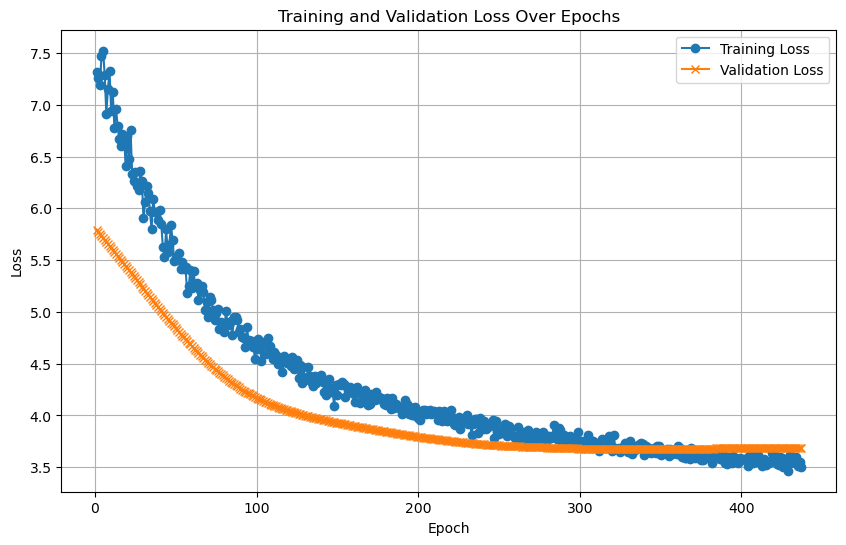

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 4.7260
Test Batch [20/20], Loss: 4.9203

Test Loss: 5.2915


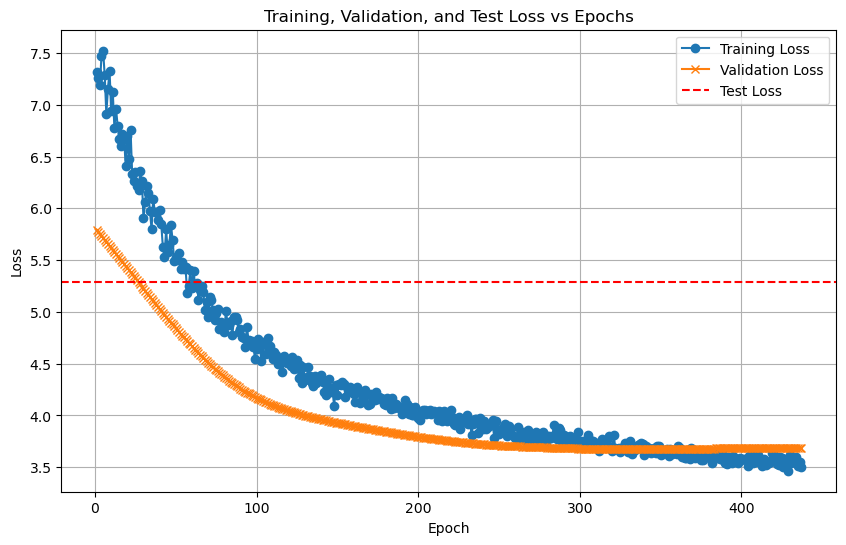

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.


  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 29.23%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.80      0.33         5
           1       0.20      0.20      0.20         5
           2       0.33      0.20      0.25         5
           3       0.00      0.00      0.00         5
           4       1.00      0.40      0.57         5
           5       0.00      0.00      0.00         5
           6       0.17      0.20      0.18         5
           7       0.22      0.40      0.29         5
           8       0.25      0.20      0.22         5
           9       0.50      0.20      0.29         5
          10       0.50      0.60      0.55         5
          11       0.29      0.40      0.33         5
          12       0.50      0.20      0.29         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6536  |  Val Loss: 2.7434
Validation loss improved from inf to 2.7434.
[Epoch 2/1000] Train Loss: 2.6431  |  Val Loss: 2.7321
Validation loss improved from 2.7434 to 2.7321.
[Epoch 3/1000] Train Loss: 2.6348  |  Val Loss: 2.7220
Validation loss improved from 2.7321 to 2.7220.
[Epoch 4/1000] Train Loss: 2.6272  |  Val Loss: 2.7143
Validation loss improved from 2.7220 to 2.7143.
[Epoch 5/1000] Train Loss: 2.6204  |  Val Loss: 2.7095
Validation loss improved from 2.7143 to 2.7095.
[Epoch 6/1000] Train Loss: 2.6157  |  Val Loss: 2.7058
Validation loss improved from 2.7095 to 2.7058.
[Epoch 7/1000] Train Loss: 2.6115  |  Val Loss: 2.7024
Validation loss improved from 2.7058 to 2.7024.
[Epoch 8/1000] Train Loss: 2.6078  |  Val Loss: 2.6991
Validation loss improved from 2.7024 to 2.6991.
[Epoch 9/1000] Train Loss: 2.6045  |  Val Loss: 2.6959
Validation loss improved from 2.6991 to 2.6959.
[Epoch 10/1000] Train Loss: 2.6010  |  Val Loss: 2.6928
Validation loss impr

[Epoch 25/1000] Train Loss: 2.5673  |  Val Loss: 2.6652
Validation loss improved from 2.6667 to 2.6652.
[Epoch 26/1000] Train Loss: 2.5653  |  Val Loss: 2.6638
Validation loss improved from 2.6652 to 2.6638.
[Epoch 27/1000] Train Loss: 2.5634  |  Val Loss: 2.6623
Validation loss improved from 2.6638 to 2.6623.
[Epoch 28/1000] Train Loss: 2.5614  |  Val Loss: 2.6607
Validation loss improved from 2.6623 to 2.6607.
[Epoch 29/1000] Train Loss: 2.5594  |  Val Loss: 2.6590
Validation loss improved from 2.6607 to 2.6590.
[Epoch 30/1000] Train Loss: 2.5575  |  Val Loss: 2.6573
Validation loss improved from 2.6590 to 2.6573.
[Epoch 31/1000] Train Loss: 2.5556  |  Val Loss: 2.6555
Validation loss improved from 2.6573 to 2.6555.
[Epoch 32/1000] Train Loss: 2.5537  |  Val Loss: 2.6540
Validation loss improved from 2.6555 to 2.6540.
[Epoch 33/1000] Train Loss: 2.5519  |  Val Loss: 2.6526
Validation loss improved from 2.6540 to 2.6526.
[Epoch 34/1000] Train Loss: 2.5501  |  Val Loss: 2.6498
Validati

[Epoch 35/1000] Train Loss: 2.5479  |  Val Loss: 2.6458
Validation loss improved from 2.6498 to 2.6458.
[Epoch 36/1000] Train Loss: 2.5453  |  Val Loss: 2.6436
Validation loss improved from 2.6458 to 2.6436.
[Epoch 37/1000] Train Loss: 2.5428  |  Val Loss: 2.6430
Validation loss improved from 2.6436 to 2.6430.
[Epoch 38/1000] Train Loss: 2.5404  |  Val Loss: 2.6421
Validation loss improved from 2.6430 to 2.6421.
[Epoch 39/1000] Train Loss: 2.5383  |  Val Loss: 2.6410
Validation loss improved from 2.6421 to 2.6410.
[Epoch 40/1000] Train Loss: 2.5362  |  Val Loss: 2.6418
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 41/1000] Train Loss: 2.5345  |  Val Loss: 2.6451
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 42/1000] Train Loss: 2.5335  |  Val Loss: 2.6486
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 43/1000] Train Loss: 2.5326  |  Val Loss: 2.6515
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 44/1000] Train Loss: 2.5318  |  Val Loss: 2.6536
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 45/1000] Train Loss: 2.5308  |  Val Loss: 2.6573
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 46/1000] Train Loss: 2.5306  |  Val Loss: 2.6623
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 47/1000] Train Loss: 2.5307  |  Val Loss: 2.6664
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 48/1000] Train Loss: 2.5309  |  Val Loss: 2.6695
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 49/1000] Train Loss: 2.5308  |  Val Loss: 2.6714
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 50/1000] Train Loss: 2.5304  |  Val Loss: 2.6722
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 5

[Epoch 68/1000] Train Loss: 2.5222  |  Val Loss: 2.6904
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 69/1000] Train Loss: 2.5214  |  Val Loss: 2.6910
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 70/1000] Train Loss: 2.5211  |  Val Loss: 2.6902
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 71/1000] Train Loss: 2.5197  |  Val Loss: 2.6905
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 72/1000] Train Loss: 2.5184  |  Val Loss: 2.6919
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 73/1000] Train Loss: 2.5177  |  Val Loss: 2.6905
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 74/1000] Train Loss: 2.5157  |  Val Loss: 2.6874
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 75/1000] Train Loss: 2.5127  |  Val Loss: 2.6844
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 76/1000] Train Loss: 2.5102  |  Val Loss: 2.6814
!! Validation loss did NOT improve !! Patience: 37/100
[

[Epoch 80/1000] Train Loss: 2.5029  |  Val Loss: 2.6694
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 81/1000] Train Loss: 2.5013  |  Val Loss: 2.6662
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 82/1000] Train Loss: 2.4998  |  Val Loss: 2.6630
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 83/1000] Train Loss: 2.4982  |  Val Loss: 2.6597
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 84/1000] Train Loss: 2.4967  |  Val Loss: 2.6565
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 85/1000] Train Loss: 2.4952  |  Val Loss: 2.6532
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 86/1000] Train Loss: 2.4937  |  Val Loss: 2.6498
!! Validation loss did NOT improve !! Patience: 47/100


[Epoch 87/1000] Train Loss: 2.4922  |  Val Loss: 2.6449
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 88/1000] Train Loss: 2.4899  |  Val Loss: 2.6389
Validation loss improved from 2.6410 to 2.6389.
[Epoch 89/1000] Train Loss: 2.4869  |  Val Loss: 2.6337
Validation loss improved from 2.6389 to 2.6337.
[Epoch 90/1000] Train Loss: 2.4842  |  Val Loss: 2.6288
Validation loss improved from 2.6337 to 2.6288.
[Epoch 91/1000] Train Loss: 2.4816  |  Val Loss: 2.6240
Validation loss improved from 2.6288 to 2.6240.
[Epoch 92/1000] Train Loss: 2.4792  |  Val Loss: 2.6194
Validation loss improved from 2.6240 to 2.6194.
[Epoch 93/1000] Train Loss: 2.4770  |  Val Loss: 2.6150
Validation loss improved from 2.6194 to 2.6150.
[Epoch 94/1000] Train Loss: 2.4748  |  Val Loss: 2.6110
Validation loss improved from 2.6150 to 2.6110.
[Epoch 95/1000] Train Loss: 2.4729  |  Val Loss: 2.6073
Validation loss improved from 2.6110 to 2.6073.
[Epoch 96/1000] Train Loss: 2.4710  |  Val Loss: 2.6037
V

[Epoch 109/1000] Train Loss: 2.4453  |  Val Loss: 2.5267
Validation loss improved from 2.5278 to 2.5267.
[Epoch 110/1000] Train Loss: 2.4438  |  Val Loss: 2.5275
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 111/1000] Train Loss: 2.4420  |  Val Loss: 2.5286
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 112/1000] Train Loss: 2.4404  |  Val Loss: 2.5299
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 113/1000] Train Loss: 2.4391  |  Val Loss: 2.5312
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 114/1000] Train Loss: 2.4380  |  Val Loss: 2.5324
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 115/1000] Train Loss: 2.4371  |  Val Loss: 2.5355
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 116/1000] Train Loss: 2.4366  |  Val Loss: 2.5397
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 117/1000] Train Loss: 2.4364  |  Val Loss: 2.5427
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 121/1000] Train Loss: 2.4360  |  Val Loss: 2.5487
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 122/1000] Train Loss: 2.4358  |  Val Loss: 2.5498
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 123/1000] Train Loss: 2.4353  |  Val Loss: 2.5507
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 124/1000] Train Loss: 2.4344  |  Val Loss: 2.5511
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 125/1000] Train Loss: 2.4335  |  Val Loss: 2.5513
!! Validation loss did NOT improve !! Patience: 16/100


[Epoch 126/1000] Train Loss: 2.4325  |  Val Loss: 2.5513
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 127/1000] Train Loss: 2.4314  |  Val Loss: 2.5512
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 128/1000] Train Loss: 2.4303  |  Val Loss: 2.5507
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 129/1000] Train Loss: 2.4293  |  Val Loss: 2.5498
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 130/1000] Train Loss: 2.4283  |  Val Loss: 2.5488
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 131/1000] Train Loss: 2.4272  |  Val Loss: 2.5479
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 132/1000] Train Loss: 2.4262  |  Val Loss: 2.5488
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 133/1000] Train Loss: 2.4250  |  Val Loss: 2.5511
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 134/1000] Train Loss: 2.4243  |  Val Loss: 2.5530
!! Validation loss did NOT improve !! Patience:

[Epoch 146/1000] Train Loss: 2.4106  |  Val Loss: 2.4908
Validation loss improved from 2.4938 to 2.4908.
[Epoch 147/1000] Train Loss: 2.4105  |  Val Loss: 2.4884
Validation loss improved from 2.4908 to 2.4884.
[Epoch 148/1000] Train Loss: 2.4103  |  Val Loss: 2.4863
Validation loss improved from 2.4884 to 2.4863.
[Epoch 149/1000] Train Loss: 2.4100  |  Val Loss: 2.4845
Validation loss improved from 2.4863 to 2.4845.
[Epoch 150/1000] Train Loss: 2.4096  |  Val Loss: 2.4830
Validation loss improved from 2.4845 to 2.4830.
[Epoch 151/1000] Train Loss: 2.4091  |  Val Loss: 2.4819
Validation loss improved from 2.4830 to 2.4819.
[Epoch 152/1000] Train Loss: 2.4085  |  Val Loss: 2.4808
Validation loss improved from 2.4819 to 2.4808.
[Epoch 153/1000] Train Loss: 2.4079  |  Val Loss: 2.4810
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 154/1000] Train Loss: 2.4069  |  Val Loss: 2.4823
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 155/1000] Train Loss: 2.4059  |  Val

[Epoch 160/1000] Train Loss: 2.4018  |  Val Loss: 2.4845
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 161/1000] Train Loss: 2.4009  |  Val Loss: 2.4842
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 162/1000] Train Loss: 2.3997  |  Val Loss: 2.4839
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 163/1000] Train Loss: 2.3982  |  Val Loss: 2.4840
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 164/1000] Train Loss: 2.3964  |  Val Loss: 2.4841
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 165/1000] Train Loss: 2.3949  |  Val Loss: 2.4841
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 166/1000] Train Loss: 2.3936  |  Val Loss: 2.4841
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 167/1000] Train Loss: 2.3925  |  Val Loss: 2.4843
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 168/1000] Train Loss: 2.3915  |  Val Loss: 2.4847
!! Validation loss did NOT improve !! Patience: 1

[Epoch 190/1000] Train Loss: 2.3759  |  Val Loss: 2.4464
Validation loss improved from 2.4467 to 2.4464.
[Epoch 191/1000] Train Loss: 2.3752  |  Val Loss: 2.4460
Validation loss improved from 2.4464 to 2.4460.
[Epoch 192/1000] Train Loss: 2.3746  |  Val Loss: 2.4457
Validation loss improved from 2.4460 to 2.4457.
[Epoch 193/1000] Train Loss: 2.3738  |  Val Loss: 2.4455
Validation loss improved from 2.4457 to 2.4455.
[Epoch 194/1000] Train Loss: 2.3729  |  Val Loss: 2.4453
Validation loss improved from 2.4455 to 2.4453.
[Epoch 195/1000] Train Loss: 2.3720  |  Val Loss: 2.4451
Validation loss improved from 2.4453 to 2.4451.
[Epoch 196/1000] Train Loss: 2.3711  |  Val Loss: 2.4449
Validation loss improved from 2.4451 to 2.4449.
[Epoch 197/1000] Train Loss: 2.3703  |  Val Loss: 2.4446
Validation loss improved from 2.4449 to 2.4446.
[Epoch 198/1000] Train Loss: 2.3695  |  Val Loss: 2.4444
Validation loss improved from 2.4446 to 2.4444.
[Epoch 199/1000] Train Loss: 2.3688  |  Val Loss: 2.444

[Epoch 206/1000] Train Loss: 2.3637  |  Val Loss: 2.4451
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 207/1000] Train Loss: 2.3631  |  Val Loss: 2.4453
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 208/1000] Train Loss: 2.3624  |  Val Loss: 2.4457
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 209/1000] Train Loss: 2.3617  |  Val Loss: 2.4461
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 210/1000] Train Loss: 2.3611  |  Val Loss: 2.4464
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 211/1000] Train Loss: 2.3605  |  Val Loss: 2.4467
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 212/1000] Train Loss: 2.3599  |  Val Loss: 2.4466
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 213/1000] Train Loss: 2.3593  |  Val Loss: 2.4476
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 214/1000] Train Loss: 2.3587  |  Val Loss: 2.4494
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 234/1000] Train Loss: 2.3433  |  Val Loss: 2.4399
Validation loss improved from 2.4418 to 2.4399.
[Epoch 235/1000] Train Loss: 2.3429  |  Val Loss: 2.4384
Validation loss improved from 2.4399 to 2.4384.
[Epoch 236/1000] Train Loss: 2.3426  |  Val Loss: 2.4372
Validation loss improved from 2.4384 to 2.4372.
[Epoch 237/1000] Train Loss: 2.3422  |  Val Loss: 2.4363
Validation loss improved from 2.4372 to 2.4363.
[Epoch 238/1000] Train Loss: 2.3418  |  Val Loss: 2.4356
Validation loss improved from 2.4363 to 2.4356.
[Epoch 239/1000] Train Loss: 2.3414  |  Val Loss: 2.4355
Validation loss improved from 2.4356 to 2.4355.
[Epoch 240/1000] Train Loss: 2.3406  |  Val Loss: 2.4361
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 241/1000] Train Loss: 2.3396  |  Val Loss: 2.4367
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 242/1000] Train Loss: 2.3387  |  Val Loss: 2.4372
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 243/1000] Train Loss: 2.3380  

[Epoch 251/1000] Train Loss: 2.3353  |  Val Loss: 2.4649
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 252/1000] Train Loss: 2.3356  |  Val Loss: 2.4684
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 253/1000] Train Loss: 2.3357  |  Val Loss: 2.4709
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 254/1000] Train Loss: 2.3357  |  Val Loss: 2.4724
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 255/1000] Train Loss: 2.3354  |  Val Loss: 2.4732
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 256/1000] Train Loss: 2.3350  |  Val Loss: 2.4736
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 257/1000] Train Loss: 2.3345  |  Val Loss: 2.4736
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 258/1000] Train Loss: 2.3340  |  Val Loss: 2.4762
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 259/1000] Train Loss: 2.3343  |  Val Loss: 2.4803
!! Validation loss did NOT improve !! Patience:

[Epoch 279/1000] Train Loss: 2.3158  |  Val Loss: 2.4316
Validation loss improved from 2.4341 to 2.4316.
[Epoch 280/1000] Train Loss: 2.3154  |  Val Loss: 2.4296
Validation loss improved from 2.4316 to 2.4296.
[Epoch 281/1000] Train Loss: 2.3150  |  Val Loss: 2.4280
Validation loss improved from 2.4296 to 2.4280.
[Epoch 282/1000] Train Loss: 2.3147  |  Val Loss: 2.4269
Validation loss improved from 2.4280 to 2.4269.
[Epoch 283/1000] Train Loss: 2.3144  |  Val Loss: 2.4259
Validation loss improved from 2.4269 to 2.4259.
[Epoch 284/1000] Train Loss: 2.3141  |  Val Loss: 2.4251
Validation loss improved from 2.4259 to 2.4251.
[Epoch 285/1000] Train Loss: 2.3138  |  Val Loss: 2.4244
Validation loss improved from 2.4251 to 2.4244.
[Epoch 286/1000] Train Loss: 2.3134  |  Val Loss: 2.4238
Validation loss improved from 2.4244 to 2.4238.
[Epoch 287/1000] Train Loss: 2.3130  |  Val Loss: 2.4231
Validation loss improved from 2.4238 to 2.4231.
[Epoch 288/1000] Train Loss: 2.3126  |  Val Loss: 2.422

[Epoch 295/1000] Train Loss: 2.3091  |  Val Loss: 2.4192
Validation loss improved from 2.4195 to 2.4192.
[Epoch 296/1000] Train Loss: 2.3085  |  Val Loss: 2.4189
Validation loss improved from 2.4192 to 2.4189.
[Epoch 297/1000] Train Loss: 2.3080  |  Val Loss: 2.4165
Validation loss improved from 2.4189 to 2.4165.
[Epoch 298/1000] Train Loss: 2.3075  |  Val Loss: 2.4136
Validation loss improved from 2.4165 to 2.4136.
[Epoch 299/1000] Train Loss: 2.3078  |  Val Loss: 2.4123
Validation loss improved from 2.4136 to 2.4123.
[Epoch 300/1000] Train Loss: 2.3083  |  Val Loss: 2.4120
Validation loss improved from 2.4123 to 2.4120.
[Epoch 301/1000] Train Loss: 2.3090  |  Val Loss: 2.4123
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 302/1000] Train Loss: 2.3098  |  Val Loss: 2.4125
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 303/1000] Train Loss: 2.3105  |  Val Loss: 2.4132
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 304/1000] Train Loss: 2.3107  

[Epoch 317/1000] Train Loss: 2.3040  |  Val Loss: 2.4173
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 318/1000] Train Loss: 2.3036  |  Val Loss: 2.4170
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 319/1000] Train Loss: 2.3031  |  Val Loss: 2.4167
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 320/1000] Train Loss: 2.3025  |  Val Loss: 2.4153
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 321/1000] Train Loss: 2.2997  |  Val Loss: 2.4136
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 322/1000] Train Loss: 2.2958  |  Val Loss: 2.4133
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 323/1000] Train Loss: 2.2928  |  Val Loss: 2.4143
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 324/1000] Train Loss: 2.2909  |  Val Loss: 2.4174
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 325/1000] Train Loss: 2.2892  |  Val Loss: 2.4213
!! Validation loss did NOT improve !! Patience:

[Epoch 330/1000] Train Loss: 2.2884  |  Val Loss: 2.4351
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 331/1000] Train Loss: 2.2881  |  Val Loss: 2.4354
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 332/1000] Train Loss: 2.2877  |  Val Loss: 2.4352
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 333/1000] Train Loss: 2.2873  |  Val Loss: 2.4347
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 334/1000] Train Loss: 2.2868  |  Val Loss: 2.4342
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 335/1000] Train Loss: 2.2863  |  Val Loss: 2.4336
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 336/1000] Train Loss: 2.2858  |  Val Loss: 2.4328
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 337/1000] Train Loss: 2.2853  |  Val Loss: 2.4320
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 338/1000] Train Loss: 2.2847  |  Val Loss: 2.4311
!! Validation loss did NOT improve !! Patience:

[Epoch 358/1000] Train Loss: 2.2745  |  Val Loss: 2.4203
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 359/1000] Train Loss: 2.2740  |  Val Loss: 2.4196
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 360/1000] Train Loss: 2.2735  |  Val Loss: 2.4188
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 361/1000] Train Loss: 2.2730  |  Val Loss: 2.4182
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 362/1000] Train Loss: 2.2726  |  Val Loss: 2.4178
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 363/1000] Train Loss: 2.2722  |  Val Loss: 2.4175
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 364/1000] Train Loss: 2.2718  |  Val Loss: 2.4195
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 365/1000] Train Loss: 2.2716  |  Val Loss: 2.4239
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 366/1000] Train Loss: 2.2720  |  Val Loss: 2.4280
!! Validation loss did NOT improve !! Patience:

[Epoch 375/1000] Train Loss: 2.2792  |  Val Loss: 2.4577
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 376/1000] Train Loss: 2.2789  |  Val Loss: 2.4573
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 377/1000] Train Loss: 2.2783  |  Val Loss: 2.4558
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 378/1000] Train Loss: 2.2772  |  Val Loss: 2.4536
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 379/1000] Train Loss: 2.2758  |  Val Loss: 2.4512
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 380/1000] Train Loss: 2.2743  |  Val Loss: 2.4487
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 381/1000] Train Loss: 2.2728  |  Val Loss: 2.4459
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 382/1000] Train Loss: 2.2713  |  Val Loss: 2.4431
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 383/1000] Train Loss: 2.2699  |  Val Loss: 2.4404
!! Validation loss did NOT improve !! Patience:

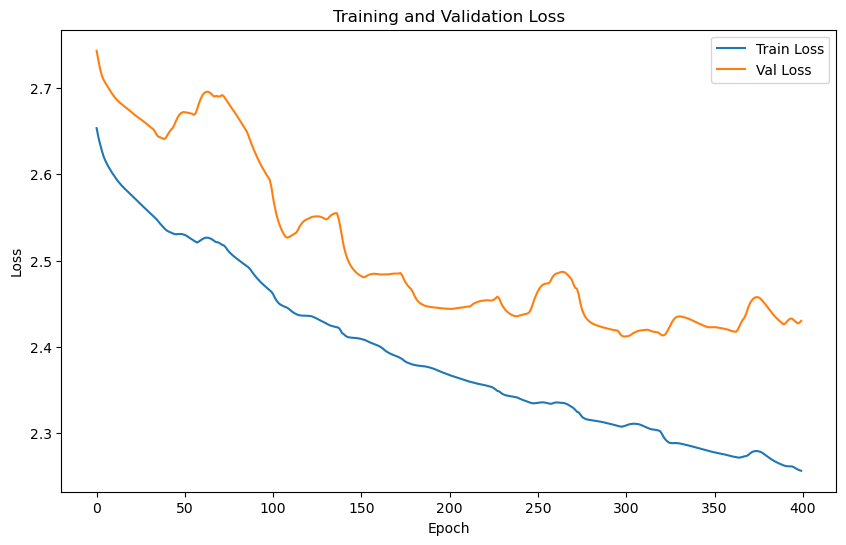

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.3130 | Test Accuracy: 21.77%


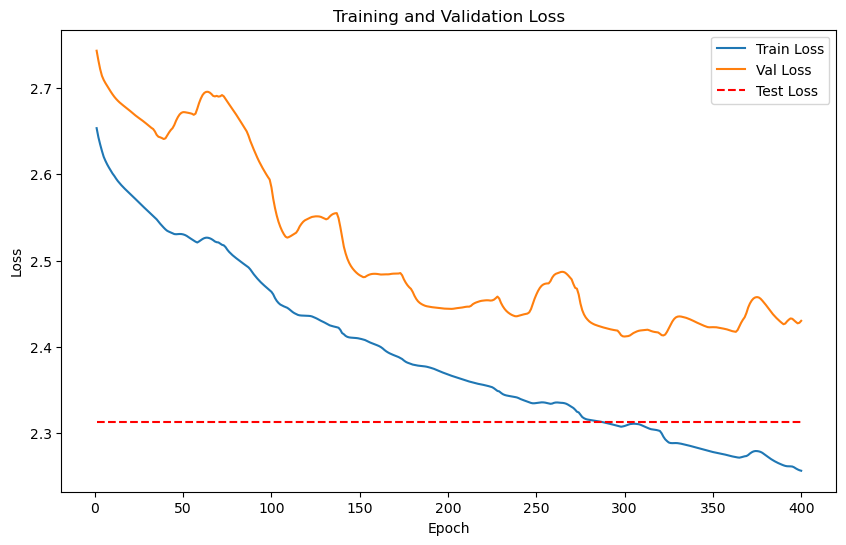

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)


Train embeddings shape: (65, 64), 
Train labels shape: (65,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5081, 64), 
Test labels shape: (5081,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}
Training batch size: 65


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5390
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5796
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5390, Avg Val Loss: 0.5398

Validation loss improved from inf to 0.5398. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.5425
LOG: Epoch [2/2000] - Validation


    Batch [1/2], Val Loss: 0.5798
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5425, Avg Val Loss: 0.5399

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5376
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5795
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5376, Avg Val Loss: 0.5398

Validation loss improved from 0.5398 to 0.5398. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.5384
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5791
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5384, Avg Val Loss: 0.5395

Validation loss improved from 0.5398 to 0.5395. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5375
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5776
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5375, Avg Val Loss: 0.5388

Validation loss improved from 0.5395 to 0.5388. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.5411
LOG: Epoch [6/2000] - Validation


    Batch [1/2], Val Loss: 0.5760
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5411, Avg Val Loss: 0.5380

Validation loss improved from 0.5388 to 0.5380. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.5396
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5754
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5396, Avg Val Loss: 0.5377

Validation loss improved from 0.5380 to 0.5377. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.5401
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5754
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5401, Avg Val Loss: 0.5377

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.5325
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5751
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5325, Avg Val Loss: 0.5376

Validation loss improved from 0.5377 to 0.5376. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5350
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5744
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5350, Avg Val Loss: 0.5372

Validation loss improved from 0.5376 to 0.5372. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.5352
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5732
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5352, Avg Val Loss: 0.5366

Validation loss improved from 0.5372 to 0.5366. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.5257
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5719
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5257, Avg Val Loss: 0.5360

Validation loss improved from 0.5366 to 0.5360. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.5333
LOG: Epoch [13/2000] - Validation


    Batch [1/2], Val Loss: 0.5709
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5333, Avg Val Loss: 0.5355

Validation loss improved from 0.5360 to 0.5355. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.5364
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5707
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5364, Avg Val Loss: 0.5354

Validation loss improved from 0.5355 to 0.5354. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.5311
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5695
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5311, Avg Val Loss: 0.5348

Validation loss improved from 0.5354 to 0.5348. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.5307
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5683
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5307, Avg Val Loss: 0.5341

Validation loss improved from 0.5348 to 0.5341. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.5259
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5669
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5259, Avg Val Loss: 0.5334

Validation loss improved from 0.5341 to 0.5334. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5290
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.5660
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5290, Avg Val Loss: 0.5330

Validation loss improved from 0.5334 to 0.5330. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5209
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5659
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5209, Avg Val Loss: 0.5330

Validation loss improved from 0.5330 to 0.5330. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.5289
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5663
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5289, Avg Val Loss: 0.5331

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.5250
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.5655
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5250, Avg Val Loss: 0.5328

Validation loss improved from 0.5330 to 0.5328. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.5294
LOG: Epoch [22/2000] - Validation


    Batch [1/2], Val Loss: 0.5640
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5294, Avg Val Loss: 0.5320

Validation loss improved from 0.5328 to 0.5320. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.5282
LOG: Epoch [23/2000] - Validation


    Batch [1/2], Val Loss: 0.5624
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5282, Avg Val Loss: 0.5312

Validation loss improved from 0.5320 to 0.5312. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.5245
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5611
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5245, Avg Val Loss: 0.5305

Validation loss improved from 0.5312 to 0.5305. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.5228
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5597
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5228, Avg Val Loss: 0.5299

Validation loss improved from 0.5305 to 0.5299. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.5245
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5588
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5245, Avg Val Loss: 0.5294

Validation loss improved from 0.5299 to 0.5294. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.5265
LOG: Epoch [27/2000] - Validation


    Batch [1/2], Val Loss: 0.5576
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5265, Avg Val Loss: 0.5288

Validation loss improved from 0.5294 to 0.5288. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.5270
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5563


    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5270, Avg Val Loss: 0.5282

Validation loss improved from 0.5288 to 0.5282. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.5233
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5556
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5233, Avg Val Loss: 0.5278

Validation loss improved from 0.5282 to 0.5278. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.5301
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5547
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5301, Avg Val Loss: 0.5273

Validation loss improved from 0.5278 to 0.5273. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.5254
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5533
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5254, Avg Val Loss: 0.5267

Validation loss improved from 0.5273 to 0.5267. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.5180
LOG: Epoch [32/2000] - Validation


    Batch [1/2], Val Loss: 0.5521
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5180, Avg Val Loss: 0.5260

Validation loss improved from 0.5267 to 0.5260. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.5290
LOG: Epoch [33/2000] - Validation


    Batch [1/2], Val Loss: 0.5503
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5290, Avg Val Loss: 0.5251

Validation loss improved from 0.5260 to 0.5251. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.5236
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5485
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5236, Avg Val Loss: 0.5243

Validation loss improved from 0.5251 to 0.5243. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.5210
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5469
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5210, Avg Val Loss: 0.5234

Validation loss improved from 0.5243 to 0.5234. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.5151
LOG: Epoch [36/2000] - Validation


    Batch [1/2], Val Loss: 0.5454
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5151, Avg Val Loss: 0.5227

Validation loss improved from 0.5234 to 0.5227. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.5111
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5439
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5111, Avg Val Loss: 0.5220

Validation loss improved from 0.5227 to 0.5220. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.5256
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5425
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5256, Avg Val Loss: 0.5213

Validation loss improved from 0.5220 to 0.5213. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.5180
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.5413
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5180, Avg Val Loss: 0.5206

Validation loss improved from 0.5213 to 0.5206. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.5216
LOG: Epoch [40/2000] - Validation


    Batch [1/2], Val Loss: 0.5402
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5216, Avg Val Loss: 0.5201

Validation loss improved from 0.5206 to 0.5201. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.5194
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5391
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5194, Avg Val Loss: 0.5196

Validation loss improved from 0.5201 to 0.5196. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.5220
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5383
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5220, Avg Val Loss: 0.5192

Validation loss improved from 0.5196 to 0.5192. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.5083
LOG: Epoch [43/2000] - Validation


    Batch [1/2], Val Loss: 0.5376
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5083, Avg Val Loss: 0.5188

Validation loss improved from 0.5192 to 0.5188. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.5192
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5368
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5192, Avg Val Loss: 0.5184

Validation loss improved from 0.5188 to 0.5184. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.5164
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5360
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5164, Avg Val Loss: 0.5180

Validation loss improved from 0.5184 to 0.5180. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.5149
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5353
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5149, Avg Val Loss: 0.5177

Validation loss improved from 0.5180 to 0.5177. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.5165
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.5347
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5165, Avg Val Loss: 0.5173

Validation loss improved from 0.5177 to 0.5173. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.5126
LOG: Epoch [48/2000] - Validation


    Batch [1/2], Val Loss: 0.5342
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5126, Avg Val Loss: 0.5171

Validation loss improved from 0.5173 to 0.5171. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.5203
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5336
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5203, Avg Val Loss: 0.5168

Validation loss improved from 0.5171 to 0.5168. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.5239
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5330
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5239, Avg Val Loss: 0.5165

Validation loss improved from 0.5168 to 0.5165. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.5167
LOG: Epoch [51/2000] - Validation


    Batch [1/2], Val Loss: 0.5324
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5167, Avg Val Loss: 0.5162

Validation loss improved from 0.5165 to 0.5162. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.5154
LOG: Epoch [52/2000] - Validation


    Batch [1/2], Val Loss: 0.5318
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5154, Avg Val Loss: 0.5159

Validation loss improved from 0.5162 to 0.5159. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.5151
LOG: Epoch [53/2000] - Validation


    Batch [1/2], Val Loss: 0.5314
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5151, Avg Val Loss: 0.5157

Validation loss improved from 0.5159 to 0.5157. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.5129
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.5309
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5129, Avg Val Loss: 0.5154

Validation loss improved from 0.5157 to 0.5154. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.5164
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5304
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5164, Avg Val Loss: 0.5152

Validation loss improved from 0.5154 to 0.5152. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.5150
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5299
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5150, Avg Val Loss: 0.5149

Validation loss improved from 0.5152 to 0.5149. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.5136
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5293
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5136, Avg Val Loss: 0.5147

Validation loss improved from 0.5149 to 0.5147. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.5108
LOG: Epoch [58/2000] - Validation


    Batch [1/2], Val Loss: 0.5289
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5108, Avg Val Loss: 0.5144

Validation loss improved from 0.5147 to 0.5144. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.5117
LOG: Epoch [59/2000] - Validation


    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.5117, Avg Val Loss: 0.5142

Validation loss improved from 0.5144 to 0.5142. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.5112
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5282
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5112, Avg Val Loss: 0.5141

Validation loss improved from 0.5142 to 0.5141. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.5146
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5280
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5146, Avg Val Loss: 0.5140

Validation loss improved from 0.5141 to 0.5140. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.5105
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5278
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5105, Avg Val Loss: 0.5139

Validation loss improved from 0.5140 to 0.5139. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.5145
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5276
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5145, Avg Val Loss: 0.5138

Validation loss improved from 0.5139 to 0.5138. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.5127
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.5274
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5127, Avg Val Loss: 0.5137

Validation loss improved from 0.5138 to 0.5137. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.5050
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5273
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5050, Avg Val Loss: 0.5136

Validation loss improved from 0.5137 to 0.5136. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.5154
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5270
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5154, Avg Val Loss: 0.5135

Validation loss improved from 0.5136 to 0.5135. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.5125
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5267
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.5125, Avg Val Loss: 0.5134

Validation loss improved from 0.5135 to 0.5134. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.5085
LOG: Epoch [68/2000] - Validation


    Batch [1/2], Val Loss: 0.5264
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5085, Avg Val Loss: 0.5132

Validation loss improved from 0.5134 to 0.5132. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.5038
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5262
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.5038, Avg Val Loss: 0.5131

Validation loss improved from 0.5132 to 0.5131. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.5135
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5259
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.5135, Avg Val Loss: 0.5129

Validation loss improved from 0.5131 to 0.5129. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.5160
LOG: Epoch [71/2000] - Validation


    Batch [1/2], Val Loss: 0.5256
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.5160, Avg Val Loss: 0.5128

Validation loss improved from 0.5129 to 0.5128. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.5074
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.5252
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.5074, Avg Val Loss: 0.5126

Validation loss improved from 0.5128 to 0.5126. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.5092
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.5092, Avg Val Loss: 0.5124

Validation loss improved from 0.5126 to 0.5124. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.5121
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5244
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.5121, Avg Val Loss: 0.5122

Validation loss improved from 0.5124 to 0.5122. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.5077
LOG: Epoch [75/2000] - Validation


    Batch [1/2], Val Loss: 0.5241
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.5077, Avg Val Loss: 0.5121

Validation loss improved from 0.5122 to 0.5121. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.5164
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.5164, Avg Val Loss: 0.5119

Validation loss improved from 0.5121 to 0.5119. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.5089
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.5234
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.5089, Avg Val Loss: 0.5117

Validation loss improved from 0.5119 to 0.5117. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.5049
LOG: Epoch [78/2000] - Validation


    Batch [1/2], Val Loss: 0.5229
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.5049, Avg Val Loss: 0.5115

Validation loss improved from 0.5117 to 0.5115. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.5089
LOG: Epoch [79/2000] - Validation


    Batch [1/2], Val Loss: 0.5226
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.5089, Avg Val Loss: 0.5113

Validation loss improved from 0.5115 to 0.5113. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.5086
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.5224
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.5086, Avg Val Loss: 0.5112

Validation loss improved from 0.5113 to 0.5112. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.5031
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.5222
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.5031, Avg Val Loss: 0.5111

Validation loss improved from 0.5112 to 0.5111. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.5115
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5221
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.5115, Avg Val Loss: 0.5110

Validation loss improved from 0.5111 to 0.5110. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.5100
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.5100, Avg Val Loss: 0.5110

Validation loss improved from 0.5110 to 0.5110. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.5053
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.5218
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.5053, Avg Val Loss: 0.5109

Validation loss improved from 0.5110 to 0.5109. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.5035
LOG: Epoch [85/2000] - Validation


    Batch [1/2], Val Loss: 0.5218
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.5109

Validation loss improved from 0.5109 to 0.5109. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.5065
LOG: Epoch [86/2000] - Validation


    Batch [1/2], Val Loss: 0.5218
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.5065, Avg Val Loss: 0.5109

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.5144
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5219


    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.5144, Avg Val Loss: 0.5109

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.5023
LOG: Epoch [88/2000] - Validation


    Batch [1/2], Val Loss: 0.5221
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.5023, Avg Val Loss: 0.5110

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.5026
LOG: Epoch [89/2000] - Validation


    Batch [1/2], Val Loss: 0.5222
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.5111

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.5150
LOG: Epoch [90/2000] - Validation


    Batch [1/2], Val Loss: 0.5223
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.5150, Avg Val Loss: 0.5112

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.5223
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.5112

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4992
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5222
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4992, Avg Val Loss: 0.5111

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.5009
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5221
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.5111

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.5077
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5220
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.5077, Avg Val Loss: 0.5110

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [95/2000] - Validation


    Batch [1/2], Val Loss: 0.5217
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.5108

Validation loss improved from 0.5109 to 0.5108. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.5045
LOG: Epoch [96/2000] - Validation


    Batch [1/2], Val Loss: 0.5215
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.5045, Avg Val Loss: 0.5107

Validation loss improved from 0.5108 to 0.5107. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.5025
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5214
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.5025, Avg Val Loss: 0.5107

Validation loss improved from 0.5107 to 0.5107. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.5004
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.5004, Avg Val Loss: 0.5106

Validation loss improved from 0.5107 to 0.5106. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.4979
LOG: Epoch [99/2000] - Validation


    Batch [1/2], Val Loss: 0.5211
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4979, Avg Val Loss: 0.5106

Validation loss improved from 0.5106 to 0.5106. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.5006
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5210
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.5006, Avg Val Loss: 0.5105

Validation loss improved from 0.5106 to 0.5105. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.5024
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.5209
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.5024, Avg Val Loss: 0.5105

Validation loss improved from 0.5105 to 0.5105. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.5056
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.5056, Avg Val Loss: 0.5104

Validation loss improved from 0.5105 to 0.5104. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [103/2000] - Validation


    Batch [1/2], Val Loss: 0.5206
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5103

Validation loss improved from 0.5104 to 0.5103. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.5205
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5102

Validation loss improved from 0.5103 to 0.5102. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.5039
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.5039, Avg Val Loss: 0.5101

Validation loss improved from 0.5102 to 0.5101. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5202
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5101

Validation loss improved from 0.5101 to 0.5101. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5100

Validation loss improved from 0.5101 to 0.5100. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.4994
LOG: Epoch [108/2000] - Validation


    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4994, Avg Val Loss: 0.5099

Validation loss improved from 0.5100 to 0.5099. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [109/2000] - Validation


    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.5098

Validation loss improved from 0.5099 to 0.5098. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.5027
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.5027, Avg Val Loss: 0.5097

Validation loss improved from 0.5098 to 0.5097. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.5193
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.5096

Validation loss improved from 0.5097 to 0.5096. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5191
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5095

Validation loss improved from 0.5096 to 0.5095. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.5189
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.5095

Validation loss improved from 0.5095 to 0.5095. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.5188
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5094

Validation loss improved from 0.5095 to 0.5094. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.5187
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5093

Validation loss improved from 0.5094 to 0.5093. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.5024
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.5184
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.5024, Avg Val Loss: 0.5092

Validation loss improved from 0.5093 to 0.5092. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.5180
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5090

Validation loss improved from 0.5092 to 0.5090. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5088

Validation loss improved from 0.5090 to 0.5088. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.5175
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.5088

Validation loss improved from 0.5088 to 0.5088. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4986
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.5087

Validation loss improved from 0.5088 to 0.5087. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.5087

Validation loss improved from 0.5087 to 0.5087. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5087

Validation loss improved from 0.5087 to 0.5087. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.5030
LOG: Epoch [123/2000] - Validation


    Batch [1/2], Val Loss: 0.5173
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.5030, Avg Val Loss: 0.5086

Validation loss improved from 0.5087 to 0.5086. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5086

Validation loss improved from 0.5086 to 0.5086. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5085

Validation loss improved from 0.5086 to 0.5085. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.5085

Validation loss improved from 0.5085 to 0.5085. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.5168
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5084

Validation loss improved from 0.5085 to 0.5084. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.5083

Validation loss improved from 0.5084 to 0.5083. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [129/2000] - Validation


    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5083

Validation loss improved from 0.5083 to 0.5083. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.4981
LOG: Epoch [130/2000] - Validation


    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.5082

Validation loss improved from 0.5083 to 0.5082. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5082

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5082

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [133/2000] - Validation


    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5082

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.5163
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5082

Validation loss improved from 0.5082 to 0.5082. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [136/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5081

Validation loss improved from 0.5082 to 0.5081. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5081

Validation loss improved from 0.5081 to 0.5081. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.5081

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.5161
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5081

Validation loss improved from 0.5081 to 0.5081. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5080

Validation loss improved from 0.5081 to 0.5080. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [141/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.5079

Validation loss improved from 0.5080 to 0.5079. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [143/2000] - Validation


    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [144/2000] - Validation


    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5079

Validation loss improved from 0.5079 to 0.5079. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [147/2000] - Validation


    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [148/2000] - Validation


    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.5080

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [149/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5081

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.5165
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.5083

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.5084

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.5173
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5086

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5088

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [154/2000] - Validation


    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.5089

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.5180
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.5090

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.5182
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.5091

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.5182
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5091

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [158/2000] - Validation


    Batch [1/2], Val Loss: 0.5182
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5091

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.5181
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5090

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.5179
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5089

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5088

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.5173
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.5087

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5084

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.5082

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [165/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.5079

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.5077

Validation loss improved from 0.5079 to 0.5077. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5076

Validation loss improved from 0.5077 to 0.5076. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.5074

Validation loss improved from 0.5076 to 0.5074. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [169/2000] - Validation


    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.5073

Validation loss improved from 0.5074 to 0.5073. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.5142
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.5071

Validation loss improved from 0.5073 to 0.5071. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.5140
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5070

Validation loss improved from 0.5071 to 0.5070. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5069

Validation loss improved from 0.5070 to 0.5069. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.5138
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.5069

Validation loss improved from 0.5069 to 0.5069. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.5137
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.5069

Validation loss improved from 0.5069 to 0.5069. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.5068

Validation loss improved from 0.5069 to 0.5068. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [176/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.5067

Validation loss improved from 0.5068 to 0.5067. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.5066

Validation loss improved from 0.5067 to 0.5066. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [178/2000] - Validation


    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.5065

Validation loss improved from 0.5066 to 0.5065. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [179/2000] - Validation


    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.5064

Validation loss improved from 0.5065 to 0.5064. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [180/2000] - Validation


    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.5062

Validation loss improved from 0.5064 to 0.5062. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.5062

Validation loss improved from 0.5062 to 0.5062. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.5062

Validation loss improved from 0.5062 to 0.5062. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.5061

Validation loss improved from 0.5062 to 0.5061. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.5122
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.5061

Validation loss improved from 0.5061 to 0.5061. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.5061

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [186/2000] - Validation


    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [190/2000] - Validation


    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [194/2000] - Validation


    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [195/2000] - Validation


    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [196/2000] - Validation


    Batch [1/2], Val Loss: 0.5126
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4761
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.5126
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [200/2000] - Validation


    Batch [1/2], Val Loss: 0.5126
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.5126
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.5121
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5061

Validation loss improved from 0.5061 to 0.5061. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5060

Validation loss improved from 0.5061 to 0.5060. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4766
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.5060

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.5060

Validation loss improved from 0.5060 to 0.5060. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5060

Validation loss improved from 0.5060 to 0.5060. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [208/2000] - Validation


    Batch [1/2], Val Loss: 0.5121
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.5061

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [209/2000] - Validation


    Batch [1/2], Val Loss: 0.5122
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.5061

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [211/2000] - Validation


    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.5061

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [214/2000] - Validation


    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.5129
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.5065

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [217/2000] - Validation


    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.5065

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5065

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5065

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [220/2000] - Validation


    Batch [1/2], Val Loss: 0.5129
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.5065

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.5122
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.5061

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.5118
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.5059

Validation loss improved from 0.5060 to 0.5059. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.5113
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.5057

Validation loss improved from 0.5059 to 0.5057. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5055

Validation loss improved from 0.5057 to 0.5055. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4716
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.5054

Validation loss improved from 0.5055 to 0.5054. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.5105
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.5053

Validation loss improved from 0.5054 to 0.5053. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.5103
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5051

Validation loss improved from 0.5053 to 0.5051. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.5100
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.5050

Validation loss improved from 0.5051 to 0.5050. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5049

Validation loss improved from 0.5050 to 0.5049. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.5048

Validation loss improved from 0.5049 to 0.5048. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [232/2000] - Validation


    Batch [1/2], Val Loss: 0.5094
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.5047

Validation loss improved from 0.5048 to 0.5047. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.5093
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5046

Validation loss improved from 0.5047 to 0.5046. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.5092
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5046

Validation loss improved from 0.5046 to 0.5046. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.5093
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.5047

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.5048

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [237/2000] - Validation


    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.5047

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [238/2000] - Validation


    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.5048

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.5048

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.5048

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.5097
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.5048

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5049

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.5049

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.5049

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [245/2000] - Validation


    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.5048

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.5094
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.5047

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.5046

Validation loss improved from 0.5046 to 0.5046. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.5044

Validation loss improved from 0.5046 to 0.5044. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [249/2000] - Validation


    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.5043

Validation loss improved from 0.5044 to 0.5043. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.5083
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.5042

Validation loss improved from 0.5043 to 0.5042. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.5081
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.5041

Validation loss improved from 0.5042 to 0.5041. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.5039

Validation loss improved from 0.5041 to 0.5039. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.5037

Validation loss improved from 0.5039 to 0.5037. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.5036

Validation loss improved from 0.5037 to 0.5036. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5034

Validation loss improved from 0.5036 to 0.5034. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [256/2000] - Validation


    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.5034

Validation loss improved from 0.5034 to 0.5034. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.5065
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.5033

Validation loss improved from 0.5034 to 0.5033. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5032

Validation loss improved from 0.5033 to 0.5032. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [259/2000] - Validation


    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.5031

Validation loss improved from 0.5032 to 0.5031. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.5030

Validation loss improved from 0.5031 to 0.5030. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.5030

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.5030

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.5030

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.5031

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5030

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.5059
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.5030

Validation loss improved from 0.5030 to 0.5030. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.5057
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.5029

Validation loss improved from 0.5030 to 0.5029. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.5056
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5028

Validation loss improved from 0.5029 to 0.5028. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [269/2000] - Validation


    Batch [1/2], Val Loss: 0.5055
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5027

Validation loss improved from 0.5028 to 0.5027. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [270/2000] - Validation


    Batch [1/2], Val Loss: 0.5054
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.5027

Validation loss improved from 0.5027 to 0.5027. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.5054
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5027

Validation loss improved from 0.5027 to 0.5027. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.5056
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.5028

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [273/2000] - Validation


    Batch [1/2], Val Loss: 0.5058
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.5029

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.5030

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.5030

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.5030

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5031

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.5062
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5031

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.5031

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [280/2000] - Validation


    Batch [1/2], Val Loss: 0.5064
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.5032

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.5064
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.5032

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.5066
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.5033

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.5034

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [284/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.5071
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.5036

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.5036

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.5071
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.5036

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [289/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5034

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.5033

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [292/2000] - Validation


    Batch [1/2], Val Loss: 0.5066
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.5033

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.5066
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.5033

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5033

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [295/2000] - Validation


    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.5034

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.5034

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.5034

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [298/2000] - Validation


    Batch [1/2], Val Loss: 0.5062
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.5031

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.5056
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.5028

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.5051
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.5026

Validation loss improved from 0.5027 to 0.5026. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [301/2000] - Validation


    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.5024

Validation loss improved from 0.5026 to 0.5024. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [302/2000] - Validation


    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.5023

Validation loss improved from 0.5024 to 0.5023. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [303/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.5022

Validation loss improved from 0.5023 to 0.5022. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [308/2000] - Validation


    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [311/2000] - Validation


    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.5042
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.5021

Validation loss improved from 0.5022 to 0.5021. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.5042
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.5021

Validation loss improved from 0.5021 to 0.5021. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [314/2000] - Validation


    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.5021

Validation loss improved from 0.5021 to 0.5021. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [315/2000] - Validation


    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5021

Validation loss improved from 0.5021 to 0.5021. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.5020

Validation loss improved from 0.5021 to 0.5020. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.5020

Validation loss improved from 0.5020 to 0.5020. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.5020

Validation loss improved from 0.5020 to 0.5020. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.5020

Validation loss improved from 0.5020 to 0.5020. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [320/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.5020

Validation loss improved from 0.5020 to 0.5020. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [321/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [322/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [325/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.5040


    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [327/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [328/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.5020

Validation loss improved from 0.5020 to 0.5020. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.5020

Validation loss improved from 0.5020 to 0.5020. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.5020

Validation loss improved from 0.5020 to 0.5020. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.5019

Validation loss improved from 0.5020 to 0.5019. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [335/2000] - Validation


    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.5019

Validation loss improved from 0.5019 to 0.5019. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.5019

Validation loss improved from 0.5019 to 0.5019. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.5019

Validation loss improved from 0.5019 to 0.5019. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.5019

Validation loss improved from 0.5019 to 0.5019. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [339/2000] - Validation


    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.5019

Validation loss improved from 0.5019 to 0.5019. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.5019

Validation loss improved from 0.5019 to 0.5019. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.5019

Validation loss improved from 0.5019 to 0.5019. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.5019

Validation loss improved from 0.5019 to 0.5019. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [343/2000] - Validation


    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.5019

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.5019

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.5019

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.5019

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [347/2000] - Validation


    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.5019

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.5019

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5019

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [350/2000] - Validation


    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.5019

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.5019

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [353/2000] - Validation


    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [356/2000] - Validation


    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [359/2000] - Validation


    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [362/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [365/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [371/2000] - Validation


    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [374/2000] - Validation


    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [375/2000] - Validation


    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [376/2000] - Validation


    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [377/2000] - Validation


    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [380/2000] - Validation


    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [385/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [386/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [389/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [393/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [398/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [399/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [400/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [403/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [404/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [405/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [406/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [407/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [410/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [414/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [415/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [421/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [426/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [427/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [431/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [432/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [433/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [434/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [437/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [438/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [439/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [442/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 442!!
No improvement for 100 epochs


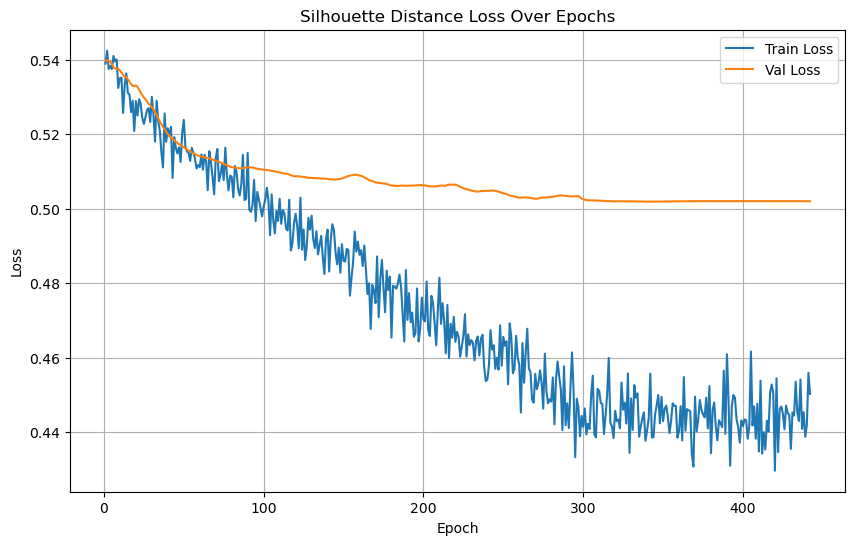

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/80], Loss: 0.2760
Test Batch [20/80], Loss: 0.5000
Test Batch [30/80], Loss: 0.3842


Test Batch [40/80], Loss: 0.2098
Test Batch [50/80], Loss: 0.3668
Test Batch [60/80], Loss: 0.3126


Test Batch [70/80], Loss: 0.4692
Test Batch [80/80], Loss: 0.5000

Test Loss: 0.3307


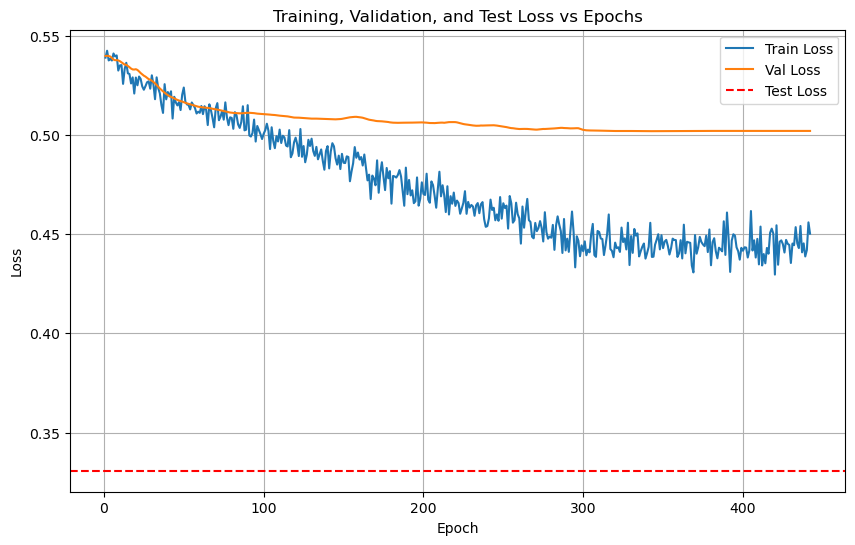

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/80 for test dataset.


  Processed batch 20/80 for test dataset.


  Processed batch 30/80 for test dataset.
  Processed batch 40/80 for test dataset.


  Processed batch 50/80 for test dataset.


  Processed batch 60/80 for test dataset.
  Processed batch 70/80 for test dataset.
  Processed batch 80/80 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 46.15%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.60      0.46         5
           1       0.00      0.00      0.00         5
           2       0.33      0.20      0.25         5
           3       0.33      0.20      0.25         5
           4       0.33      0.20      0.25         5
           5       1.00      0.20      0.33         5
           6       0.33      1.00      0.50         5
           7       0.44      0.80      0.57         5
           8       0.80      0.80      0.80         5
           9       0.50      0.40      0.44         5
          10       0.71      1.00      0.83         5
          11       0.25      0.20      0.22         5
          12       1.00      0.40      0.57         5

    accuracy         

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5712  |  Val Loss: 2.5811
Validation loss improved from inf to 2.5811.
[Epoch 2/1000] Train Loss: 2.5607  |  Val Loss: 2.5774
Validation loss improved from 2.5811 to 2.5774.
[Epoch 3/1000] Train Loss: 2.5519  |  Val Loss: 2.5741
Validation loss improved from 2.5774 to 2.5741.
[Epoch 4/1000] Train Loss: 2.5439  |  Val Loss: 2.5714
Validation loss improved from 2.5741 to 2.5714.
[Epoch 5/1000] Train Loss: 2.5370  |  Val Loss: 2.5688
Validation loss improved from 2.5714 to 2.5688.
[Epoch 6/1000] Train Loss: 2.5299  |  Val Loss: 2.5663
Validation loss improved from 2.5688 to 2.5663.
[Epoch 7/1000] Train Loss: 2.5244  |  Val Loss: 2.5640
Validation loss improved from 2.5663 to 2.5640.
[Epoch 8/1000] Train Loss: 2.5189  |  Val Loss: 2.5619
Validation loss improved from 2.5640 to 2.5619.
[Epoch 9/1000] Train Loss: 2.5140  |  Val Loss: 2.5599
Validation loss improved from 2.5619 to 2.5599.
[Epoch 10/1000] Train Loss: 2.5092  |  Val Loss: 2.5580
Validation loss impr

[Epoch 25/1000] Train Loss: 2.4609  |  Val Loss: 2.5343
Validation loss improved from 2.5357 to 2.5343.
[Epoch 26/1000] Train Loss: 2.4580  |  Val Loss: 2.5326
Validation loss improved from 2.5343 to 2.5326.
[Epoch 27/1000] Train Loss: 2.4542  |  Val Loss: 2.5305
Validation loss improved from 2.5326 to 2.5305.
[Epoch 28/1000] Train Loss: 2.4498  |  Val Loss: 2.5285
Validation loss improved from 2.5305 to 2.5285.
[Epoch 29/1000] Train Loss: 2.4454  |  Val Loss: 2.5266
Validation loss improved from 2.5285 to 2.5266.
[Epoch 30/1000] Train Loss: 2.4416  |  Val Loss: 2.5249
Validation loss improved from 2.5266 to 2.5249.
[Epoch 31/1000] Train Loss: 2.4382  |  Val Loss: 2.5233
Validation loss improved from 2.5249 to 2.5233.
[Epoch 32/1000] Train Loss: 2.4350  |  Val Loss: 2.5218
Validation loss improved from 2.5233 to 2.5218.
[Epoch 33/1000] Train Loss: 2.4320  |  Val Loss: 2.5203
Validation loss improved from 2.5218 to 2.5203.
[Epoch 34/1000] Train Loss: 2.4292  |  Val Loss: 2.5188
Validati

[Epoch 38/1000] Train Loss: 2.4195  |  Val Loss: 2.5134
Validation loss improved from 2.5148 to 2.5134.
[Epoch 39/1000] Train Loss: 2.4170  |  Val Loss: 2.5118
Validation loss improved from 2.5134 to 2.5118.
[Epoch 40/1000] Train Loss: 2.4142  |  Val Loss: 2.5103
Validation loss improved from 2.5118 to 2.5103.
[Epoch 41/1000] Train Loss: 2.4115  |  Val Loss: 2.5088
Validation loss improved from 2.5103 to 2.5088.
[Epoch 42/1000] Train Loss: 2.4089  |  Val Loss: 2.5075
Validation loss improved from 2.5088 to 2.5075.
[Epoch 43/1000] Train Loss: 2.4066  |  Val Loss: 2.5061
Validation loss improved from 2.5075 to 2.5061.
[Epoch 44/1000] Train Loss: 2.4044  |  Val Loss: 2.5049
Validation loss improved from 2.5061 to 2.5049.
[Epoch 45/1000] Train Loss: 2.4023  |  Val Loss: 2.5037
Validation loss improved from 2.5049 to 2.5037.
[Epoch 46/1000] Train Loss: 2.4003  |  Val Loss: 2.5026
Validation loss improved from 2.5037 to 2.5026.
[Epoch 47/1000] Train Loss: 2.3984  |  Val Loss: 2.5015
Validati

[Epoch 72/1000] Train Loss: 2.3481  |  Val Loss: 2.4735
Validation loss improved from 2.4744 to 2.4735.
[Epoch 73/1000] Train Loss: 2.3466  |  Val Loss: 2.4726
Validation loss improved from 2.4735 to 2.4726.
[Epoch 74/1000] Train Loss: 2.3452  |  Val Loss: 2.4717
Validation loss improved from 2.4726 to 2.4717.
[Epoch 75/1000] Train Loss: 2.3438  |  Val Loss: 2.4708
Validation loss improved from 2.4717 to 2.4708.
[Epoch 76/1000] Train Loss: 2.3425  |  Val Loss: 2.4699
Validation loss improved from 2.4708 to 2.4699.
[Epoch 77/1000] Train Loss: 2.3411  |  Val Loss: 2.4689
Validation loss improved from 2.4699 to 2.4689.
[Epoch 78/1000] Train Loss: 2.3397  |  Val Loss: 2.4679
Validation loss improved from 2.4689 to 2.4679.
[Epoch 79/1000] Train Loss: 2.3382  |  Val Loss: 2.4669
Validation loss improved from 2.4679 to 2.4669.
[Epoch 80/1000] Train Loss: 2.3366  |  Val Loss: 2.4659
Validation loss improved from 2.4669 to 2.4659.
[Epoch 81/1000] Train Loss: 2.3350  |  Val Loss: 2.4647
Validati

[Epoch 84/1000] Train Loss: 2.3290  |  Val Loss: 2.4607
Validation loss improved from 2.4619 to 2.4607.
[Epoch 85/1000] Train Loss: 2.3271  |  Val Loss: 2.4595
Validation loss improved from 2.4607 to 2.4595.
[Epoch 86/1000] Train Loss: 2.3252  |  Val Loss: 2.4584
Validation loss improved from 2.4595 to 2.4584.
[Epoch 87/1000] Train Loss: 2.3235  |  Val Loss: 2.4574
Validation loss improved from 2.4584 to 2.4574.
[Epoch 88/1000] Train Loss: 2.3217  |  Val Loss: 2.4565
Validation loss improved from 2.4574 to 2.4565.
[Epoch 89/1000] Train Loss: 2.3201  |  Val Loss: 2.4555
Validation loss improved from 2.4565 to 2.4555.
[Epoch 90/1000] Train Loss: 2.3184  |  Val Loss: 2.4543
Validation loss improved from 2.4555 to 2.4543.
[Epoch 91/1000] Train Loss: 2.3165  |  Val Loss: 2.4530
Validation loss improved from 2.4543 to 2.4530.
[Epoch 92/1000] Train Loss: 2.3145  |  Val Loss: 2.4517
Validation loss improved from 2.4530 to 2.4517.
[Epoch 93/1000] Train Loss: 2.3127  |  Val Loss: 2.4506
Validati

[Epoch 117/1000] Train Loss: 2.2683  |  Val Loss: 2.4311
Validation loss improved from 2.4317 to 2.4311.
[Epoch 118/1000] Train Loss: 2.2667  |  Val Loss: 2.4304
Validation loss improved from 2.4311 to 2.4304.
[Epoch 119/1000] Train Loss: 2.2647  |  Val Loss: 2.4291
Validation loss improved from 2.4304 to 2.4291.
[Epoch 120/1000] Train Loss: 2.2620  |  Val Loss: 2.4276
Validation loss improved from 2.4291 to 2.4276.
[Epoch 121/1000] Train Loss: 2.2595  |  Val Loss: 2.4264
Validation loss improved from 2.4276 to 2.4264.
[Epoch 122/1000] Train Loss: 2.2572  |  Val Loss: 2.4253
Validation loss improved from 2.4264 to 2.4253.
[Epoch 123/1000] Train Loss: 2.2552  |  Val Loss: 2.4244
Validation loss improved from 2.4253 to 2.4244.
[Epoch 124/1000] Train Loss: 2.2534  |  Val Loss: 2.4235
Validation loss improved from 2.4244 to 2.4235.


[Epoch 125/1000] Train Loss: 2.2515  |  Val Loss: 2.4228
Validation loss improved from 2.4235 to 2.4228.
[Epoch 126/1000] Train Loss: 2.2499  |  Val Loss: 2.4222
Validation loss improved from 2.4228 to 2.4222.
[Epoch 127/1000] Train Loss: 2.2482  |  Val Loss: 2.4214
Validation loss improved from 2.4222 to 2.4214.
[Epoch 128/1000] Train Loss: 2.2464  |  Val Loss: 2.4206
Validation loss improved from 2.4214 to 2.4206.
[Epoch 129/1000] Train Loss: 2.2444  |  Val Loss: 2.4199
Validation loss improved from 2.4206 to 2.4199.
[Epoch 130/1000] Train Loss: 2.2426  |  Val Loss: 2.4193
Validation loss improved from 2.4199 to 2.4193.
[Epoch 131/1000] Train Loss: 2.2409  |  Val Loss: 2.4187
Validation loss improved from 2.4193 to 2.4187.
[Epoch 132/1000] Train Loss: 2.2394  |  Val Loss: 2.4182
Validation loss improved from 2.4187 to 2.4182.
[Epoch 133/1000] Train Loss: 2.2380  |  Val Loss: 2.4175
Validation loss improved from 2.4182 to 2.4175.
[Epoch 134/1000] Train Loss: 2.2366  |  Val Loss: 2.416

[Epoch 154/1000] Train Loss: 2.2118  |  Val Loss: 2.4079
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 155/1000] Train Loss: 2.2102  |  Val Loss: 2.4081
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 156/1000] Train Loss: 2.2088  |  Val Loss: 2.4083
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 157/1000] Train Loss: 2.2074  |  Val Loss: 2.4084
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 158/1000] Train Loss: 2.2061  |  Val Loss: 2.4084
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 159/1000] Train Loss: 2.2049  |  Val Loss: 2.4082
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 160/1000] Train Loss: 2.2036  |  Val Loss: 2.4078
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 161/1000] Train Loss: 2.2023  |  Val Loss: 2.4074
Validation loss improved from 2.4076 to 2.4074.
[Epoch 162/1000] Train Loss: 2.2010  |  Val Loss: 2.4069
Validation loss improved from 2.4074 to 2.4069.
[Epoch 163/10

[Epoch 167/1000] Train Loss: 2.1951  |  Val Loss: 2.4048
Validation loss improved from 2.4053 to 2.4048.
[Epoch 168/1000] Train Loss: 2.1937  |  Val Loss: 2.4044
Validation loss improved from 2.4048 to 2.4044.
[Epoch 169/1000] Train Loss: 2.1925  |  Val Loss: 2.4039
Validation loss improved from 2.4044 to 2.4039.
[Epoch 170/1000] Train Loss: 2.1913  |  Val Loss: 2.4035
Validation loss improved from 2.4039 to 2.4035.
[Epoch 171/1000] Train Loss: 2.1902  |  Val Loss: 2.4031
Validation loss improved from 2.4035 to 2.4031.
[Epoch 172/1000] Train Loss: 2.1891  |  Val Loss: 2.4027
Validation loss improved from 2.4031 to 2.4027.
[Epoch 173/1000] Train Loss: 2.1880  |  Val Loss: 2.4023
Validation loss improved from 2.4027 to 2.4023.
[Epoch 174/1000] Train Loss: 2.1869  |  Val Loss: 2.4023
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 175/1000] Train Loss: 2.1858  |  Val Loss: 2.4026
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 176/1000] Train Loss: 2.1845  |  Val

[Epoch 197/1000] Train Loss: 2.1499  |  Val Loss: 2.3831
Validation loss improved from 2.3840 to 2.3831.
[Epoch 198/1000] Train Loss: 2.1484  |  Val Loss: 2.3821
Validation loss improved from 2.3831 to 2.3821.
[Epoch 199/1000] Train Loss: 2.1469  |  Val Loss: 2.3811
Validation loss improved from 2.3821 to 2.3811.
[Epoch 200/1000] Train Loss: 2.1454  |  Val Loss: 2.3801
Validation loss improved from 2.3811 to 2.3801.
[Epoch 201/1000] Train Loss: 2.1440  |  Val Loss: 2.3792
Validation loss improved from 2.3801 to 2.3792.
[Epoch 202/1000] Train Loss: 2.1427  |  Val Loss: 2.3782
Validation loss improved from 2.3792 to 2.3782.
[Epoch 203/1000] Train Loss: 2.1414  |  Val Loss: 2.3772
Validation loss improved from 2.3782 to 2.3772.
[Epoch 204/1000] Train Loss: 2.1400  |  Val Loss: 2.3764
Validation loss improved from 2.3772 to 2.3764.
[Epoch 205/1000] Train Loss: 2.1388  |  Val Loss: 2.3757
Validation loss improved from 2.3764 to 2.3757.
[Epoch 206/1000] Train Loss: 2.1376  |  Val Loss: 2.375

[Epoch 207/1000] Train Loss: 2.1364  |  Val Loss: 2.3746
Validation loss improved from 2.3751 to 2.3746.
[Epoch 208/1000] Train Loss: 2.1353  |  Val Loss: 2.3742
Validation loss improved from 2.3746 to 2.3742.
[Epoch 209/1000] Train Loss: 2.1340  |  Val Loss: 2.3737
Validation loss improved from 2.3742 to 2.3737.
[Epoch 210/1000] Train Loss: 2.1328  |  Val Loss: 2.3734
Validation loss improved from 2.3737 to 2.3734.
[Epoch 211/1000] Train Loss: 2.1316  |  Val Loss: 2.3732
Validation loss improved from 2.3734 to 2.3732.
[Epoch 212/1000] Train Loss: 2.1304  |  Val Loss: 2.3729
Validation loss improved from 2.3732 to 2.3729.
[Epoch 213/1000] Train Loss: 2.1293  |  Val Loss: 2.3726
Validation loss improved from 2.3729 to 2.3726.
[Epoch 214/1000] Train Loss: 2.1283  |  Val Loss: 2.3724
Validation loss improved from 2.3726 to 2.3724.
[Epoch 215/1000] Train Loss: 2.1273  |  Val Loss: 2.3724
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 216/1000] Train Loss: 2.1263  |  Val Loss:

[Epoch 235/1000] Train Loss: 2.1054  |  Val Loss: 2.3822
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 236/1000] Train Loss: 2.1041  |  Val Loss: 2.3816
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 237/1000] Train Loss: 2.1030  |  Val Loss: 2.3810
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 238/1000] Train Loss: 2.1019  |  Val Loss: 2.3803
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 239/1000] Train Loss: 2.1007  |  Val Loss: 2.3795
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 240/1000] Train Loss: 2.0993  |  Val Loss: 2.3785
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 241/1000] Train Loss: 2.0980  |  Val Loss: 2.3776
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 242/1000] Train Loss: 2.0968  |  Val Loss: 2.3767
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 243/1000] Train Loss: 2.0956  |  Val Loss: 2.3759
!! Validation loss did NOT improve !! Patience:

[Epoch 249/1000] Train Loss: 2.0891  |  Val Loss: 2.3721
Validation loss improved from 2.3723 to 2.3721.
[Epoch 250/1000] Train Loss: 2.0879  |  Val Loss: 2.3717
Validation loss improved from 2.3721 to 2.3717.
[Epoch 251/1000] Train Loss: 2.0865  |  Val Loss: 2.3714
Validation loss improved from 2.3717 to 2.3714.
[Epoch 252/1000] Train Loss: 2.0853  |  Val Loss: 2.3712
Validation loss improved from 2.3714 to 2.3712.
[Epoch 253/1000] Train Loss: 2.0841  |  Val Loss: 2.3709
Validation loss improved from 2.3712 to 2.3709.
[Epoch 254/1000] Train Loss: 2.0829  |  Val Loss: 2.3715
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 255/1000] Train Loss: 2.0817  |  Val Loss: 2.3724
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 256/1000] Train Loss: 2.0803  |  Val Loss: 2.3729
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 257/1000] Train Loss: 2.0788  |  Val Loss: 2.3730
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 258/1000] Train Loss: 2.

[Epoch 276/1000] Train Loss: 2.0583  |  Val Loss: 2.3705
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 277/1000] Train Loss: 2.0574  |  Val Loss: 2.3701
Validation loss improved from 2.3704 to 2.3701.
[Epoch 278/1000] Train Loss: 2.0564  |  Val Loss: 2.3695
Validation loss improved from 2.3701 to 2.3695.
[Epoch 279/1000] Train Loss: 2.0555  |  Val Loss: 2.3691
Validation loss improved from 2.3695 to 2.3691.
[Epoch 280/1000] Train Loss: 2.0546  |  Val Loss: 2.3686
Validation loss improved from 2.3691 to 2.3686.
[Epoch 281/1000] Train Loss: 2.0536  |  Val Loss: 2.3680
Validation loss improved from 2.3686 to 2.3680.
[Epoch 282/1000] Train Loss: 2.0526  |  Val Loss: 2.3673
Validation loss improved from 2.3680 to 2.3673.
[Epoch 283/1000] Train Loss: 2.0516  |  Val Loss: 2.3667
Validation loss improved from 2.3673 to 2.3667.
[Epoch 284/1000] Train Loss: 2.0507  |  Val Loss: 2.3665
Validation loss improved from 2.3667 to 2.3665.
[Epoch 285/1000] Train Loss: 2.0497  |  Val Loss:

[Epoch 294/1000] Train Loss: 2.0382  |  Val Loss: 2.3552
Validation loss improved from 2.3566 to 2.3552.
[Epoch 295/1000] Train Loss: 2.0367  |  Val Loss: 2.3539
Validation loss improved from 2.3552 to 2.3539.
[Epoch 296/1000] Train Loss: 2.0353  |  Val Loss: 2.3528
Validation loss improved from 2.3539 to 2.3528.
[Epoch 297/1000] Train Loss: 2.0340  |  Val Loss: 2.3520
Validation loss improved from 2.3528 to 2.3520.
[Epoch 298/1000] Train Loss: 2.0328  |  Val Loss: 2.3511
Validation loss improved from 2.3520 to 2.3511.
[Epoch 299/1000] Train Loss: 2.0314  |  Val Loss: 2.3503
Validation loss improved from 2.3511 to 2.3503.
[Epoch 300/1000] Train Loss: 2.0299  |  Val Loss: 2.3495
Validation loss improved from 2.3503 to 2.3495.
[Epoch 301/1000] Train Loss: 2.0285  |  Val Loss: 2.3489
Validation loss improved from 2.3495 to 2.3489.
[Epoch 302/1000] Train Loss: 2.0273  |  Val Loss: 2.3483
Validation loss improved from 2.3489 to 2.3483.
[Epoch 303/1000] Train Loss: 2.0261  |  Val Loss: 2.347

[Epoch 319/1000] Train Loss: 2.0101  |  Val Loss: 2.3396
Validation loss improved from 2.3400 to 2.3396.
[Epoch 320/1000] Train Loss: 2.0091  |  Val Loss: 2.3390
Validation loss improved from 2.3396 to 2.3390.
[Epoch 321/1000] Train Loss: 2.0080  |  Val Loss: 2.3391
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 322/1000] Train Loss: 2.0066  |  Val Loss: 2.3399
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 323/1000] Train Loss: 2.0053  |  Val Loss: 2.3406
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 324/1000] Train Loss: 2.0040  |  Val Loss: 2.3410
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 325/1000] Train Loss: 2.0028  |  Val Loss: 2.3421
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 326/1000] Train Loss: 2.0016  |  Val Loss: 2.3438
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 327/1000] Train Loss: 2.0005  |  Val Loss: 2.3454
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 328/10

[Epoch 336/1000] Train Loss: 1.9882  |  Val Loss: 2.3468
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 337/1000] Train Loss: 1.9870  |  Val Loss: 2.3464
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 338/1000] Train Loss: 1.9858  |  Val Loss: 2.3460
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 339/1000] Train Loss: 1.9847  |  Val Loss: 2.3455
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 340/1000] Train Loss: 1.9836  |  Val Loss: 2.3450
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 341/1000] Train Loss: 1.9825  |  Val Loss: 2.3445
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 342/1000] Train Loss: 1.9814  |  Val Loss: 2.3448
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 343/1000] Train Loss: 1.9803  |  Val Loss: 2.3454
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 344/1000] Train Loss: 1.9790  |  Val Loss: 2.3468
!! Validation loss did NOT improve !! Patience:

[Epoch 364/1000] Train Loss: 1.9534  |  Val Loss: 2.3522
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 365/1000] Train Loss: 1.9523  |  Val Loss: 2.3517
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 366/1000] Train Loss: 1.9513  |  Val Loss: 2.3513
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 367/1000] Train Loss: 1.9503  |  Val Loss: 2.3506
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 368/1000] Train Loss: 1.9491  |  Val Loss: 2.3496
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 369/1000] Train Loss: 1.9479  |  Val Loss: 2.3489
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 370/1000] Train Loss: 1.9466  |  Val Loss: 2.3485
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 371/1000] Train Loss: 1.9454  |  Val Loss: 2.3482
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 372/1000] Train Loss: 1.9442  |  Val Loss: 2.3476
!! Validation loss did NOT improve !! Patience:

[Epoch 377/1000] Train Loss: 1.9370  |  Val Loss: 2.3419
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 378/1000] Train Loss: 1.9358  |  Val Loss: 2.3407
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 379/1000] Train Loss: 1.9346  |  Val Loss: 2.3397
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 380/1000] Train Loss: 1.9335  |  Val Loss: 2.3388
Validation loss improved from 2.3390 to 2.3388.
[Epoch 381/1000] Train Loss: 1.9324  |  Val Loss: 2.3379
Validation loss improved from 2.3388 to 2.3379.
[Epoch 382/1000] Train Loss: 1.9314  |  Val Loss: 2.3370
Validation loss improved from 2.3379 to 2.3370.
[Epoch 383/1000] Train Loss: 1.9303  |  Val Loss: 2.3361
Validation loss improved from 2.3370 to 2.3361.
[Epoch 384/1000] Train Loss: 1.9292  |  Val Loss: 2.3353
Validation loss improved from 2.3361 to 2.3353.
[Epoch 385/1000] Train Loss: 1.9281  |  Val Loss: 2.3345
Validation loss improved from 2.3353 to 2.3345.
[Epoch 386/1000] Train Loss: 1.927

[Epoch 404/1000] Train Loss: 1.9075  |  Val Loss: 2.3323
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 405/1000] Train Loss: 1.9062  |  Val Loss: 2.3326
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 406/1000] Train Loss: 1.9047  |  Val Loss: 2.3328
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 407/1000] Train Loss: 1.9034  |  Val Loss: 2.3327
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 408/1000] Train Loss: 1.9021  |  Val Loss: 2.3324
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 409/1000] Train Loss: 1.9009  |  Val Loss: 2.3315
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 410/1000] Train Loss: 1.8996  |  Val Loss: 2.3300
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 411/1000] Train Loss: 1.8984  |  Val Loss: 2.3287
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 412/1000] Train Loss: 1.8970  |  Val Loss: 2.3278
Validation loss improved from 2.3283 to 2.3278.


[Epoch 421/1000] Train Loss: 1.8855  |  Val Loss: 2.3227
Validation loss improved from 2.3232 to 2.3227.
[Epoch 422/1000] Train Loss: 1.8845  |  Val Loss: 2.3220
Validation loss improved from 2.3227 to 2.3220.
[Epoch 423/1000] Train Loss: 1.8834  |  Val Loss: 2.3207
Validation loss improved from 2.3220 to 2.3207.
[Epoch 424/1000] Train Loss: 1.8823  |  Val Loss: 2.3188
Validation loss improved from 2.3207 to 2.3188.
[Epoch 425/1000] Train Loss: 1.8812  |  Val Loss: 2.3169
Validation loss improved from 2.3188 to 2.3169.
[Epoch 426/1000] Train Loss: 1.8798  |  Val Loss: 2.3152
Validation loss improved from 2.3169 to 2.3152.
[Epoch 427/1000] Train Loss: 1.8782  |  Val Loss: 2.3139
Validation loss improved from 2.3152 to 2.3139.
[Epoch 428/1000] Train Loss: 1.8765  |  Val Loss: 2.3129
Validation loss improved from 2.3139 to 2.3129.
[Epoch 429/1000] Train Loss: 1.8750  |  Val Loss: 2.3120
Validation loss improved from 2.3129 to 2.3120.
[Epoch 430/1000] Train Loss: 1.8735  |  Val Loss: 2.311

[Epoch 449/1000] Train Loss: 1.8439  |  Val Loss: 2.3045
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 450/1000] Train Loss: 1.8425  |  Val Loss: 2.3047
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 451/1000] Train Loss: 1.8412  |  Val Loss: 2.3046
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 452/1000] Train Loss: 1.8399  |  Val Loss: 2.3059
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 453/1000] Train Loss: 1.8387  |  Val Loss: 2.3084
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 454/1000] Train Loss: 1.8373  |  Val Loss: 2.3102
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 455/1000] Train Loss: 1.8359  |  Val Loss: 2.3111
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 456/1000] Train Loss: 1.8343  |  Val Loss: 2.3118
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 457/1000] Train Loss: 1.8326  |  Val Loss: 2.3124
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 465/1000] Train Loss: 1.8208  |  Val Loss: 2.3149
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 466/1000] Train Loss: 1.8194  |  Val Loss: 2.3151
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 467/1000] Train Loss: 1.8181  |  Val Loss: 2.3151
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 468/1000] Train Loss: 1.8168  |  Val Loss: 2.3150
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 469/1000] Train Loss: 1.8156  |  Val Loss: 2.3148
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 470/1000] Train Loss: 1.8145  |  Val Loss: 2.3146
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 471/1000] Train Loss: 1.8132  |  Val Loss: 2.3142
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 472/1000] Train Loss: 1.8118  |  Val Loss: 2.3139
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 473/1000] Train Loss: 1.8104  |  Val Loss: 2.3142
!! Validation loss did NOT improve !! Patience:

[Epoch 490/1000] Train Loss: 1.7889  |  Val Loss: 2.2975
Validation loss improved from 2.2992 to 2.2975.
[Epoch 491/1000] Train Loss: 1.7875  |  Val Loss: 2.2963
Validation loss improved from 2.2975 to 2.2963.
[Epoch 492/1000] Train Loss: 1.7861  |  Val Loss: 2.2952
Validation loss improved from 2.2963 to 2.2952.
[Epoch 493/1000] Train Loss: 1.7848  |  Val Loss: 2.2943
Validation loss improved from 2.2952 to 2.2943.
[Epoch 494/1000] Train Loss: 1.7835  |  Val Loss: 2.2937
Validation loss improved from 2.2943 to 2.2937.
[Epoch 495/1000] Train Loss: 1.7821  |  Val Loss: 2.2932
Validation loss improved from 2.2937 to 2.2932.
[Epoch 496/1000] Train Loss: 1.7808  |  Val Loss: 2.2929
Validation loss improved from 2.2932 to 2.2929.
[Epoch 497/1000] Train Loss: 1.7796  |  Val Loss: 2.2928
Validation loss improved from 2.2929 to 2.2928.
[Epoch 498/1000] Train Loss: 1.7785  |  Val Loss: 2.2927
Validation loss improved from 2.2928 to 2.2927.
[Epoch 499/1000] Train Loss: 1.7772  |  Val Loss: 2.292

[Epoch 507/1000] Train Loss: 1.7659  |  Val Loss: 2.2895
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 508/1000] Train Loss: 1.7645  |  Val Loss: 2.2902
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 509/1000] Train Loss: 1.7632  |  Val Loss: 2.2907
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 510/1000] Train Loss: 1.7619  |  Val Loss: 2.2906
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 511/1000] Train Loss: 1.7606  |  Val Loss: 2.2902
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 512/1000] Train Loss: 1.7592  |  Val Loss: 2.2896
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 513/1000] Train Loss: 1.7578  |  Val Loss: 2.2891
Validation loss improved from 2.2892 to 2.2891.
[Epoch 514/1000] Train Loss: 1.7565  |  Val Loss: 2.2887
Validation loss improved from 2.2891 to 2.2887.
[Epoch 515/1000] Train Loss: 1.7551  |  Val Loss: 2.2883
Validation loss improved from 2.2887 to 2.2883.
[Epoch 516/1000] Tr

[Epoch 527/1000] Train Loss: 1.7352  |  Val Loss: 2.2881
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 528/1000] Train Loss: 1.7336  |  Val Loss: 2.2886
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 529/1000] Train Loss: 1.7319  |  Val Loss: 2.2892
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 530/1000] Train Loss: 1.7301  |  Val Loss: 2.2897
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 531/1000] Train Loss: 1.7285  |  Val Loss: 2.2901
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 532/1000] Train Loss: 1.7269  |  Val Loss: 2.2905
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 533/1000] Train Loss: 1.7254  |  Val Loss: 2.2912
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 534/1000] Train Loss: 1.7239  |  Val Loss: 2.2922
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 535/1000] Train Loss: 1.7224  |  Val Loss: 2.2930
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 544/1000] Train Loss: 1.7084  |  Val Loss: 2.2913
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 545/1000] Train Loss: 1.7069  |  Val Loss: 2.2922
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 546/1000] Train Loss: 1.7054  |  Val Loss: 2.2927
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 547/1000] Train Loss: 1.7039  |  Val Loss: 2.2932
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 548/1000] Train Loss: 1.7023  |  Val Loss: 2.2933
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 549/1000] Train Loss: 1.7007  |  Val Loss: 2.2935
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 550/1000] Train Loss: 1.6992  |  Val Loss: 2.2940
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 551/1000] Train Loss: 1.6978  |  Val Loss: 2.2936
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 552/1000] Train Loss: 1.6962  |  Val Loss: 2.2924
!! Validation loss did NOT improve !! Patience:

[Epoch 570/1000] Train Loss: 1.6692  |  Val Loss: 2.3006
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 571/1000] Train Loss: 1.6678  |  Val Loss: 2.3017
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 572/1000] Train Loss: 1.6664  |  Val Loss: 2.3027
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 573/1000] Train Loss: 1.6650  |  Val Loss: 2.3036
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 574/1000] Train Loss: 1.6634  |  Val Loss: 2.3043
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 575/1000] Train Loss: 1.6620  |  Val Loss: 2.3050
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 576/1000] Train Loss: 1.6605  |  Val Loss: 2.3055
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 577/1000] Train Loss: 1.6590  |  Val Loss: 2.3058
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 578/1000] Train Loss: 1.6575  |  Val Loss: 2.3059
!! Validation loss did NOT improve !! Patience:

[Epoch 585/1000] Train Loss: 1.6477  |  Val Loss: 2.3083
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 586/1000] Train Loss: 1.6463  |  Val Loss: 2.3089
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 587/1000] Train Loss: 1.6448  |  Val Loss: 2.3095
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 588/1000] Train Loss: 1.6434  |  Val Loss: 2.3102
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 589/1000] Train Loss: 1.6421  |  Val Loss: 2.3106
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 590/1000] Train Loss: 1.6408  |  Val Loss: 2.3102
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 591/1000] Train Loss: 1.6393  |  Val Loss: 2.3094
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 592/1000] Train Loss: 1.6379  |  Val Loss: 2.3090
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 593/1000] Train Loss: 1.6365  |  Val Loss: 2.3086
!! Validation loss did NOT improve !! Patience:

[Epoch 611/1000] Train Loss: 1.6096  |  Val Loss: 2.3070
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 612/1000] Train Loss: 1.6081  |  Val Loss: 2.3077
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 613/1000] Train Loss: 1.6066  |  Val Loss: 2.3084
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 614/1000] Train Loss: 1.6052  |  Val Loss: 2.3088
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 615/1000] Train Loss: 1.6039  |  Val Loss: 2.3091
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 616/1000] Train Loss: 1.6027  |  Val Loss: 2.3094
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 617/1000] Train Loss: 1.6014  |  Val Loss: 2.3098
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 618/1000] Train Loss: 1.6001  |  Val Loss: 2.3103
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 619/1000] Train Loss: 1.5989  |  Val Loss: 2.3109
!! Validation loss did NOT improve !! Patience:

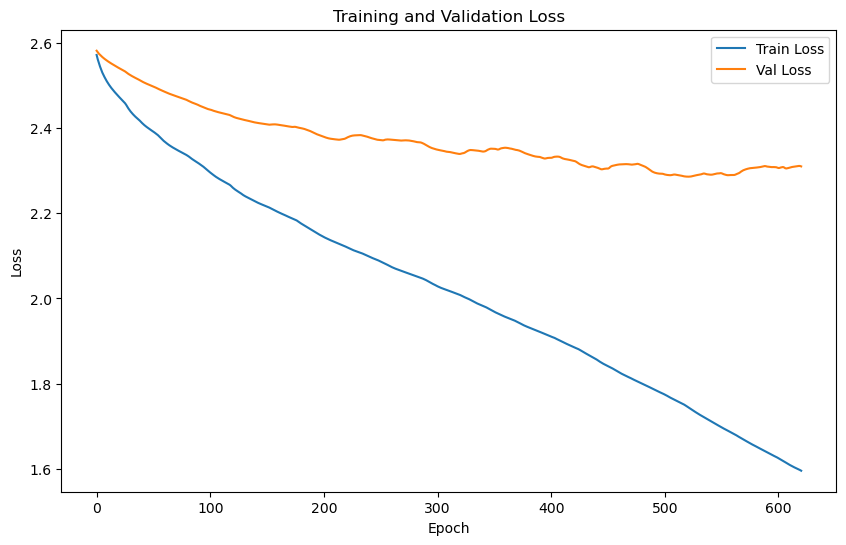

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.2210 | Test Accuracy: 43.79%


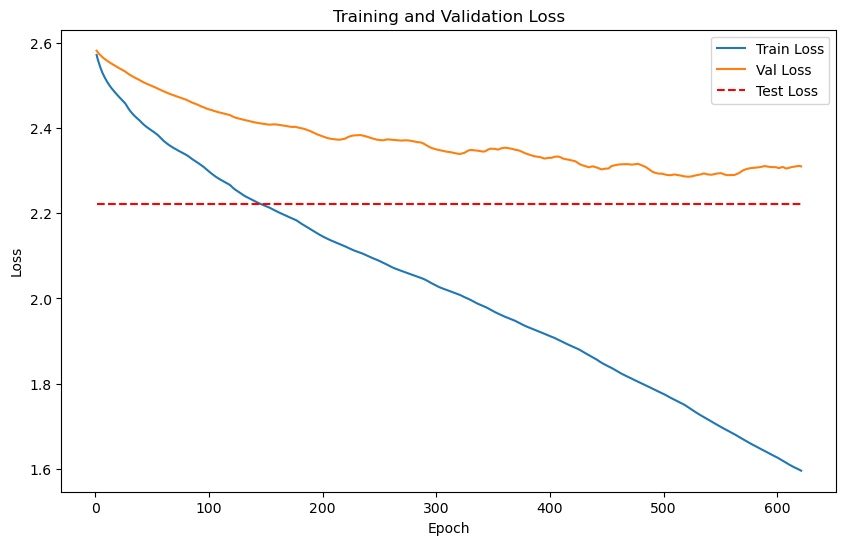

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


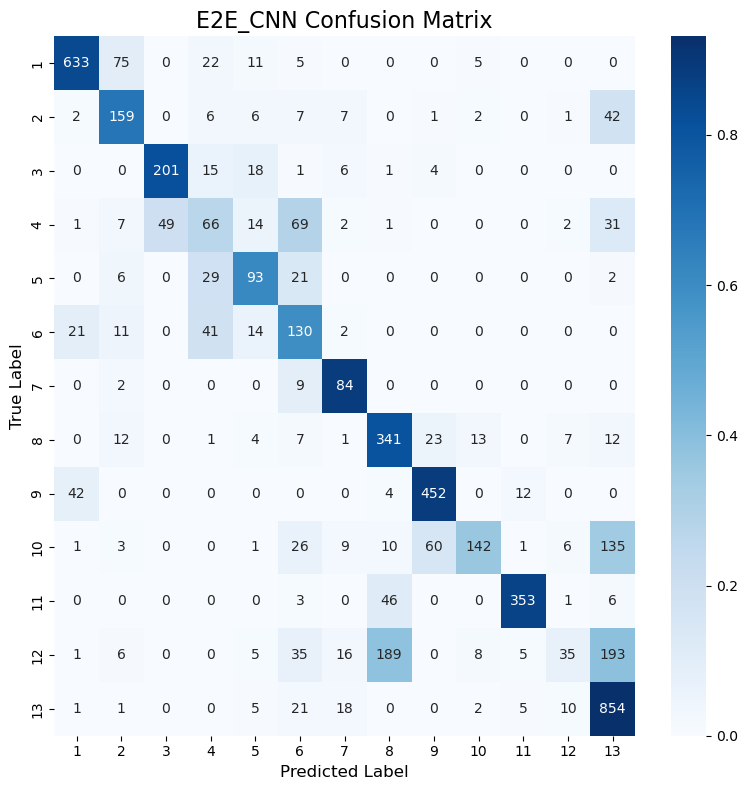

Classification Accuracy: 69.73%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


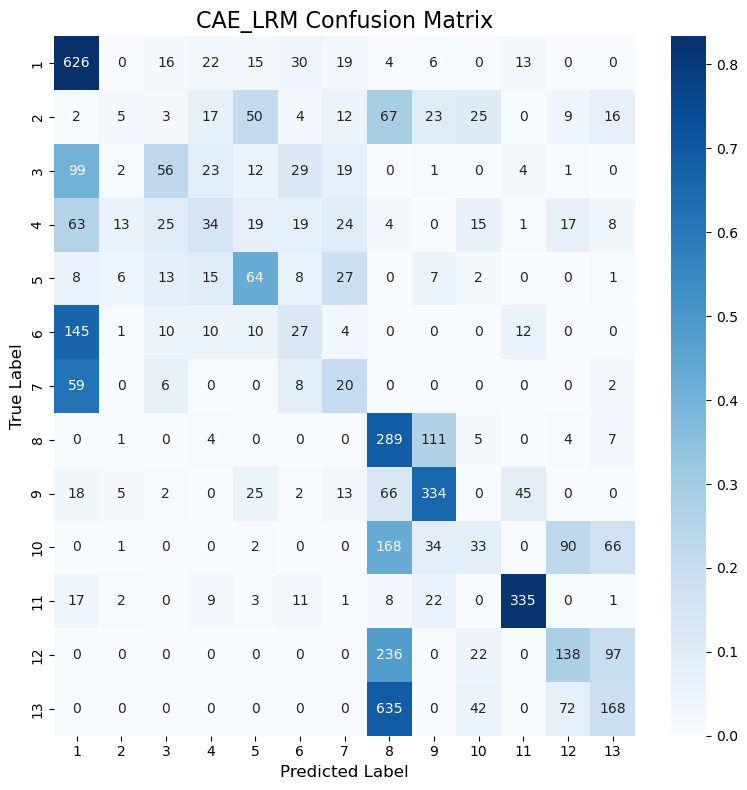

Classification Accuracy: 41.90%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


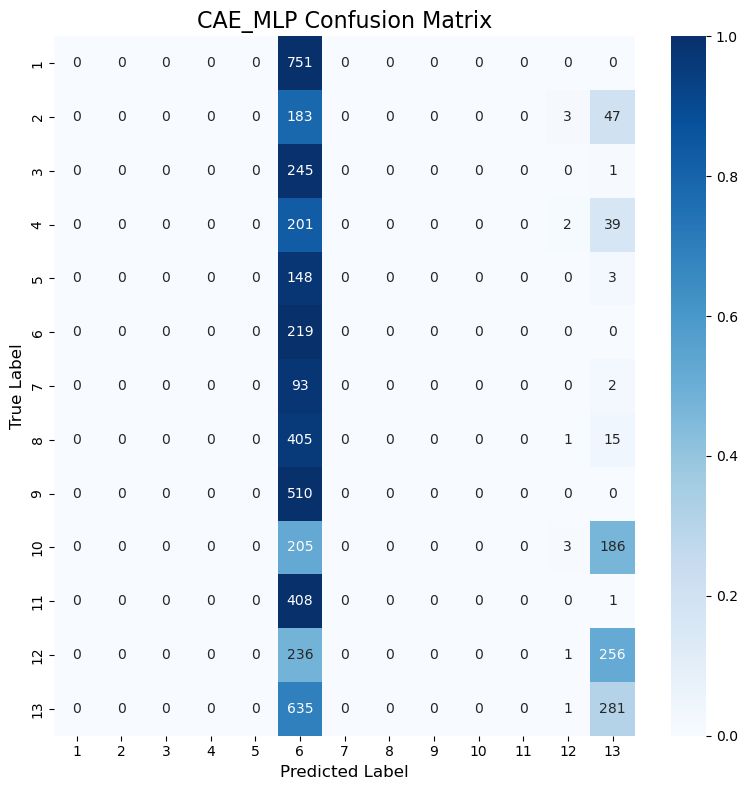

Classification Accuracy: 9.86%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


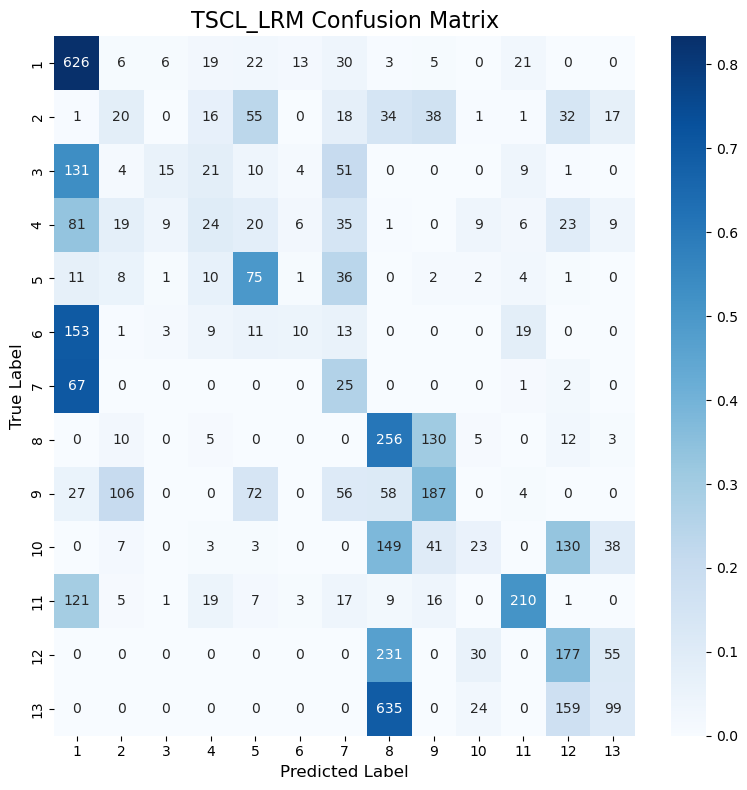

Classification Accuracy: 34.38%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


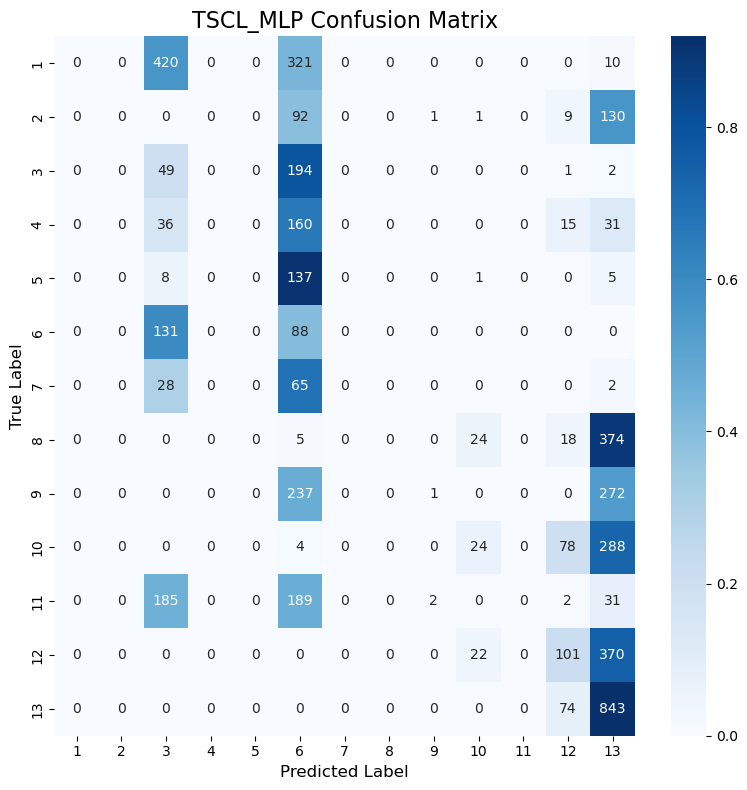

Classification Accuracy: 21.77%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


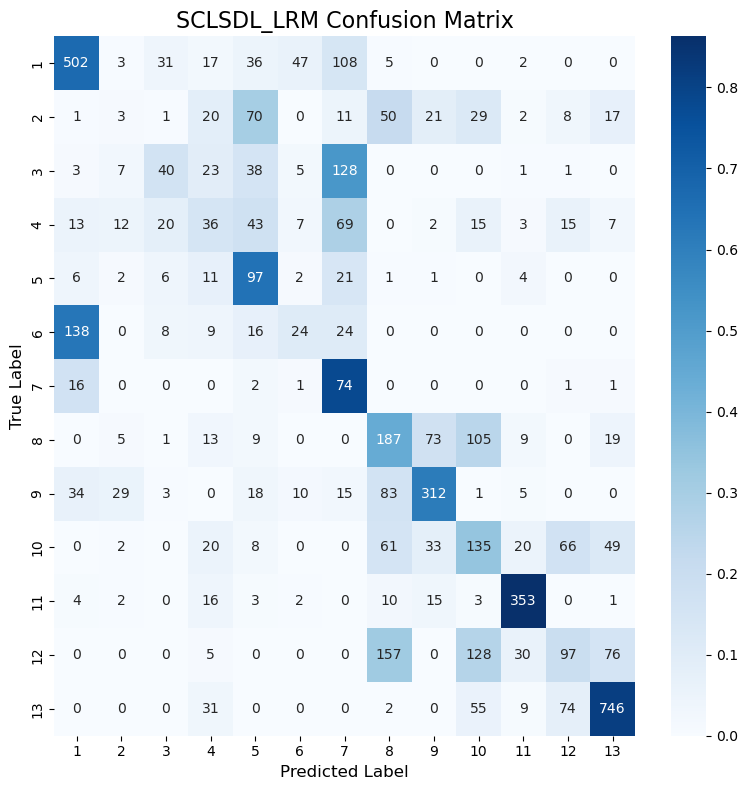

Classification Accuracy: 51.29%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


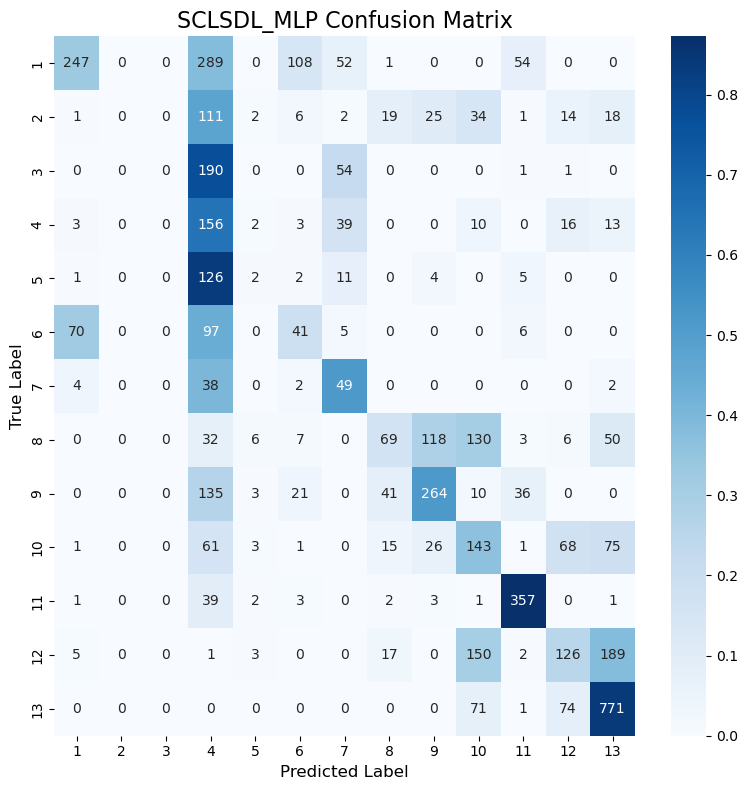

Classification Accuracy: 43.79%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          69.73
1    LRM (CAE)          41.90
2    MLP (CAE)           9.86
3     TSCL LRM          34.38
4     TSCL MLP          21.77
5  SCL_SDL LRM          51.29
6  SCL_SDL MLP          43.79

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          69.73
5  SCL_SDL LRM          51.29
6  SCL_SDL MLP          43.79
1    LRM (CAE)          41.90
3     TSCL LRM          34.38
4     TSCL MLP          21.77
2    MLP (CAE)           9.86
